### Use this file for running the complete pipeline 
- in order to see graph at every step change DEBUG to True 
- to perform event based analysis change event based analysis to True

# COMPLETE PIPELINE
- loading data 
- resampling 
- reorientation 
- filtering 
- segmentation 
- features extraction 
- training 
- testing

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.interpolate import BPoly
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from scipy.signal import butter,filtfilt, lfilter
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC,LinearSVC
import pywt
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from sklearn.impute import KNNImputer
from geopy import distance
from scipy.signal import iirdesign as iir
import os
from scipy import signal 
import librosa

# DECLARING GLOBAL PARAMS

In [5]:
path_to_filters = ''
sliding_window_size = 50
overlap = 0.5 
resampling_freq = 50
start_time = 26.651
tuning_time = 1
reorientation_type = 'euler'
plot_3d = False
custom_filters = {}
filt_name_arr = ['butter_orig'] # in order to see original [0] = 'butter_orig' else [0] = 'xyz'
# it has to be hardcoded now bcz start time of label data and acc data are differnet and we need to reference it to
# accn data 
plot_hm = False
DEBUG = False
event_based_analysis = False

# LOADING DATA 
#### this is the data after the pre-processing steps- 
- remove duplicates 
- label data sampled at 0.5Hz
- upscaling at 40 Hz
- downsacling at 25 Hz 

In [6]:
acc_data_cleaned = pd.read_pickle('../data/acc_data/21march2024/pickledData/pickled6.pkl')
label_data_cleaned = pd.read_csv('../data/labels/21March2024/2024-03-21 16_50_00-punasrtncross_devadhephata.csv')
acc_data_raw = pd.read_csv('../data/acc_data/21march2024/rawData/punasrtncross_devadhephataAccData2024-03-21 16_49_51.csv')

In [7]:
date = '21March2024'
data_num = 6

In [8]:
# from pre_process import PreSample, StandardPreProcessor
# acc_data_cleaned = StandardPreProcessor(acc_data_raw).get_preprocess_data()
# acc_data_cleaned = PreSample(acc_data_cleaned).get_presample_data()

In [9]:
# if 'accTime' not in acc_data_cleaned:
#     acc_data_cleaned.rename(columns = {'Time': 'accTime'}, inplace = True) 
if 'Latitude' not in acc_data_cleaned:
    acc_data_cleaned.rename(columns = {'Lat': 'Latitude'}, inplace = True) 
    acc_data_cleaned.rename(columns = {'Lng': 'Longitude'}, inplace = True) 
if 'accTime' not in acc_data_raw:
    acc_data_raw.rename(columns = {'Time': 'accTime'}, inplace = True) 
if 'Latitude' not in acc_data_raw:
    acc_data_raw.rename(columns = {'Lat': 'Latitude'}, inplace = True) 
    acc_data_raw.rename(columns = {'Lng': 'Longitude'}, inplace = True) 

### GETTING LABEL DATA IN THE CORRECT TIME FRAME

In [10]:
if label_data_cleaned['Time'].dtype != float:
    from datetime import datetime
    time = label_data_cleaned['Time']
    time = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S:%f') for x in time]
    time = pd.Series(time)
    time = time.apply(lambda x: x.timestamp())

    time_ = acc_data_raw['accTime']
    time_ = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S:%f') for x in time_]
    time_ = pd.Series(time_)
    time_ = time_.apply(lambda x: x.timestamp())

    time = time - time_[0]
    label_data_cleaned['Time'] = time
    label_data_cleaned.head()

## PLOTTING RAW DATA

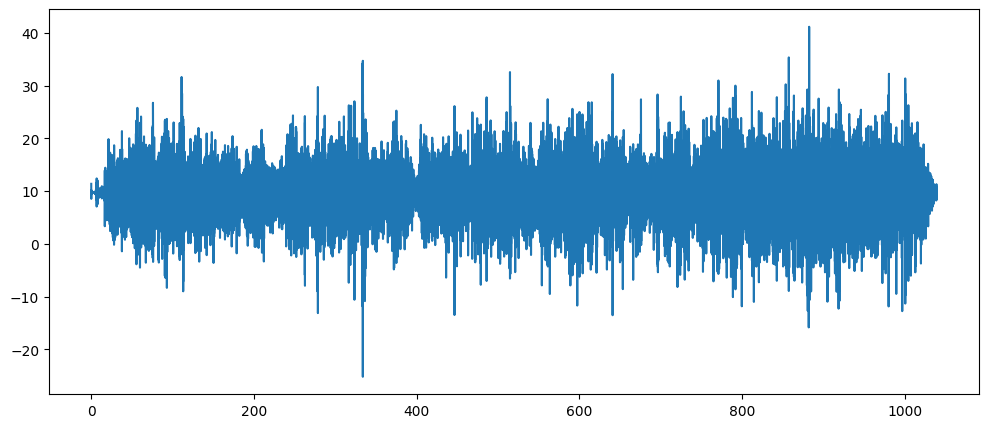

In [11]:
acc_data = pd.read_csv('../data/acc_data/17thApril2024/dattamanadir_talawadefata_AccData_2024-04-17 12_44_Auto.csv')
label_data = pd.read_csv('../data/labels/17thApril2024/2024-04-17 12_44_42-dattamandir_talawadefata.csv')
from datetime import datetime
time = acc_data['accTime']
time = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S:%f') for x in time]
time = pd.Series(time)
time = time.apply(lambda x: x.timestamp())

time_ = label_data['Time']
time_ = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S:%f') for x in time_]
time_ = pd.Series(time_)
time_ = time_.apply(lambda x: x.timestamp())

time = time - time[0]
time_ = time_ - time[0]

acc_data['accTime'] = time
label_data['Time'] = time
plt.figure(figsize=(12,5))
plt.plot(acc_data['accTime'], acc_data['y_acc'])



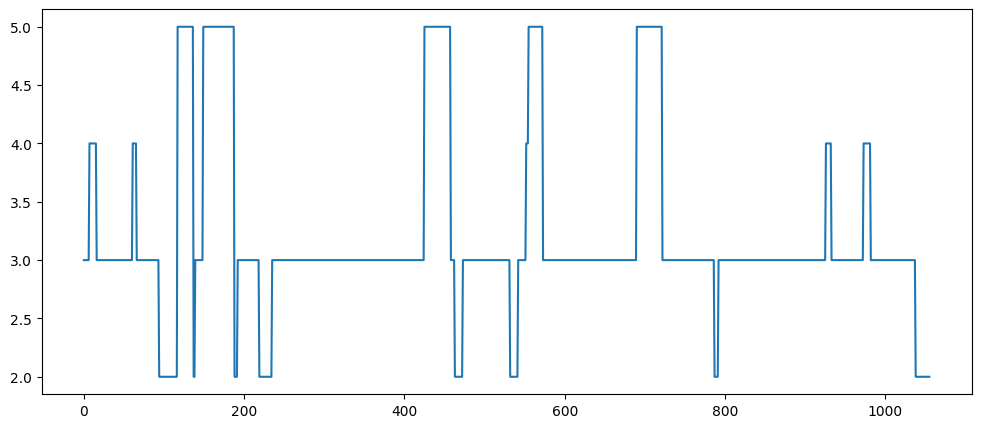

In [12]:
label_data = pd.read_csv('../data/labels/17thApril2024/2024-04-17 12_44_42-dattamandir_talawadefata.csv')
plt.figure(figsize=(12,5))
plt.plot(label_data['Label'])

In [13]:
if DEBUG:
    toi = (350,950)

    plt.figure(figsize=(12,5))
    plt.plot(acc_data_cleaned[(acc_data_cleaned['Time']>toi[0]) & (acc_data_cleaned['Time']<toi[1])]['Time'],
             acc_data_cleaned[(acc_data_cleaned['Time']>toi[0]) & (acc_data_cleaned['Time']<toi[1])]['y_acc'],
             color='red')

    plt.plot(label_data_cleaned[(label_data_cleaned['Time']>toi[0]) & (label_data_cleaned['Time']<toi[1])]['Time'],
             label_data_cleaned[(label_data_cleaned['Time']>toi[0]) & (label_data_cleaned['Time']<toi[1])]['Label'],
             color='g')
    plt.grid()
    plt.show()

###### CALCULATING MOVING AVERAGE

In [14]:
z_acc = acc_data_cleaned['z_acc']
temp = []
for i in range(len(z_acc)-10):
    avg = np.mean(z_acc[i:i+10])
    temp.append(avg)

In [15]:
if DEBUG:
    plt.figure(figsize=(12,5))
    plt.plot(temp)
    plt.plot()

# RESAMPLING 
we will be fitting a bernstien polynomial to the given sample data and the resample it at 50 Hz to get uniform freq data 

In [16]:
def fit_BPoly(df, resampling_freq):
    x_acc = np.reshape(df['x_acc'], (-1,1))
    y_acc = np.reshape(df['y_acc'], (-1,1))
    z_acc = np.reshape(df['z_acc'], (-1,1))
    t = np.array(df['Time'])
    #fitting data 
    bpoly_x = BPoly.from_derivatives(t, x_acc)
    bpoly_y = BPoly.from_derivatives(t, y_acc)
    bpoly_z = BPoly.from_derivatives(t, z_acc)
    #resampling @50Hz
    resample_t = np.linspace(0, t[-1], int(resampling_freq * t[-1]))
#     print(resample_t)
    resample_x_acc = bpoly_x(resample_t)
    resample_y_acc = bpoly_y(resample_t)
    resample_z_acc = bpoly_z(resample_t)
    #creating a new df
    df_new = pd.DataFrame({'Time': resample_t, 'x_acc': resample_x_acc, 'y_acc': resample_y_acc, 'z_acc': resample_z_acc})
    return df_new
    

In [17]:
acc_data_new = fit_BPoly(acc_data_cleaned, resampling_freq)
acc_data_new.head()

,Time,x_acc,y_acc,z_acc
0,0.000000,-0.002651,0.020406,-0.118334
1,0.020001,-0.005269,0.022127,-0.098232
2,0.040002,-0.007887,0.023849,-0.078132
3,0.060003,-0.007887,0.023849,-0.078132
4,0.080003,-0.007887,0.023849,-0.078132


### VISUALISING DATA AFTER FITTING BERNSTIEN

In [18]:
#mention time range in seconds
if DEBUG:
    time_of_interest = (5,6) #to see the entire graph use (0,t[-1])
    time_original = acc_data_cleaned[(acc_data_cleaned['Time'] < time_of_interest[1]) & (acc_data_cleaned['Time'] > time_of_interest[0])]['Time']
    x_acc_orig = acc_data_cleaned[(acc_data_cleaned['Time'] < time_of_interest[1]) & (acc_data_cleaned['Time'] > time_of_interest[0])]['x_acc']
    y_acc_orig = acc_data_cleaned[(acc_data_cleaned['Time'] < time_of_interest[1]) & (acc_data_cleaned['Time'] > time_of_interest[0])]['y_acc']
    z_acc_orig = acc_data_cleaned[(acc_data_cleaned['Time'] < time_of_interest[1]) & (acc_data_cleaned['Time'] > time_of_interest[0])]['z_acc']

    fig,ax = plt.subplots(nrows=3,ncols=1, figsize=(8,15))

    ax[0].plot(time_original, x_acc_orig, label = 'pre resampling', color='green', linewidth = 2 , marker='o', linestyle='-', alpha = 0.7)
    ax[0].plot(acc_data_new['Time'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
               acc_data_new['x_acc'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
               label = 'post resampling', color = 'red',linewidth=2, linestyle='--')
    #ax[0].plot(label_data_cleaned[(label_data_cleaned['Time'] < time_of_interest[1]) & (label_data_cleaned['Time'] > time_of_interest[0])]['Time'], 
    #            label_data_cleaned[(label_data_cleaned['Time'] < time_of_interest[1]) & (label_data_cleaned['Time'] > time_of_interest[0])]['Label'],
    #            label='labels', color='blue')
    ax[0].set_title('x_acc vs Time')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(time_original, y_acc_orig, label = 'pre resampling', color='green', linewidth = 2, marker='o', linestyle='-', alpha=0.7)
    # ax[1].plot(acc_data_new['Time'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
    #            acc_data_new['y_acc'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
    #            label = 'resampled data', color = 'blue',linewidth=2, linestyle='-', marker='o')
    ax[1].plot(acc_data_new['Time'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
               acc_data_new['y_acc'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
               label = 'fitted curve', color = 'red',linewidth=2, linestyle='--')
    # ax[1].plot(label_data_cleaned[(label_data_cleaned['Time'] < time_of_interest[1]) & (label_data_cleaned['Time'] > time_of_interest[0])]['Time'], 
    #            label_data_cleaned[(label_data_cleaned['Time'] < time_of_interest[1]) & (label_data_cleaned['Time'] > time_of_interest[0])]['Label'],
    #            label='labels', color='blue')
    
    ax[1].set_title('y_acc vs Time')
    ax[1].legend()
    ax[1].grid()

    ax[2].plot(time_original, z_acc_orig, label = 'pre resampling', linewidth=2, color='green', marker='o', linestyle='-', alpha=0.7)
    ax[2].plot(acc_data_new['Time'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
               acc_data_new['z_acc'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
               label = 'post resampling', color = 'red',linewidth=2, linestyle='--')
    # ax[2].plot(resample_t[int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
    #            resample_z_acc[int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)], 
    #            label = 'post resampling', color = 'green', linewidth=1)
    ax[2].set_title('z_acc vs Time')
    ax[2].legend()
    ax[2].grid()

    plt.show()


In [19]:
def get_distance(df):
    distances = np.array([float(distance.geodesic((df['Latitude'].iloc[i-1], df['Longitude'].iloc[i-1]),
                      (df['Latitude'].iloc[i], df['Longitude'].iloc[i])).meters)
             for i in range(1, len(df))])
    distances = np.insert(distances, 0,0)
    return distances


In [20]:
def get_velocity (df):
    p_time, p_vel, prev, prev_prev, per_vel_chng = 0, 0, 0, 0, 0
    velocity = np.zeros(len(df))
    p_vel_arr = np.zeros(len(df))
    n_vel_arr = np.zeros(len(df))
    per_vel_chng_arr = np.zeros(len(df))
    for i in range (0, len(df)):
        if df['distance'][i] != 0:
            p_vel_arr[prev:i] = p_vel
            vel = df['distance'][i]/(df['Time'][i]- p_time)
            if vel != 0:
                per_vel_chng = (vel-p_vel)/vel
            per_vel_chng_arr[prev:i] = per_vel_chng
            velocity[prev:i] = vel
            n_vel_arr[prev_prev: prev] = vel
            prev_prev = prev
            p_time, p_vel, prev = df['Time'][i], vel, i

    velocity[prev: len(df)] = p_vel
    per_vel_chng_arr[prev:len(df)] = per_vel_chng
    df['Velocity'] = velocity
    df['Per_Vel_Chng'] = per_vel_chng_arr
    df['Previous_velocity'] = p_vel_arr
    df['Next_velocity'] = n_vel_arr
    return df
    

## CALCULTAING VELOCITY 

#### calculating distane at places where lat long change

In [21]:
acc_data_cleaned['distance'] = get_distance(acc_data_cleaned)
acc_data_cleaned = get_velocity(acc_data_cleaned)

#### plot distance vs time 

In [22]:
DEBUG = False

In [23]:
DEBUG = True

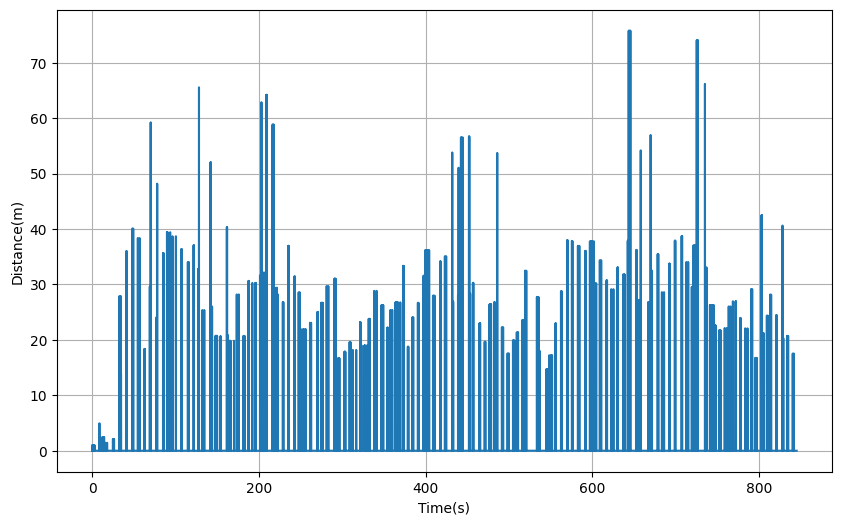

In [24]:
if DEBUG:
    plt.figure(figsize=(10,6))
    plt.plot(acc_data_cleaned['Time'], acc_data_cleaned['distance'])
    plt.ylabel('Distance(m)')
    plt.xlabel('Time(s)')
    plt.grid()

#### plotting velocity against time

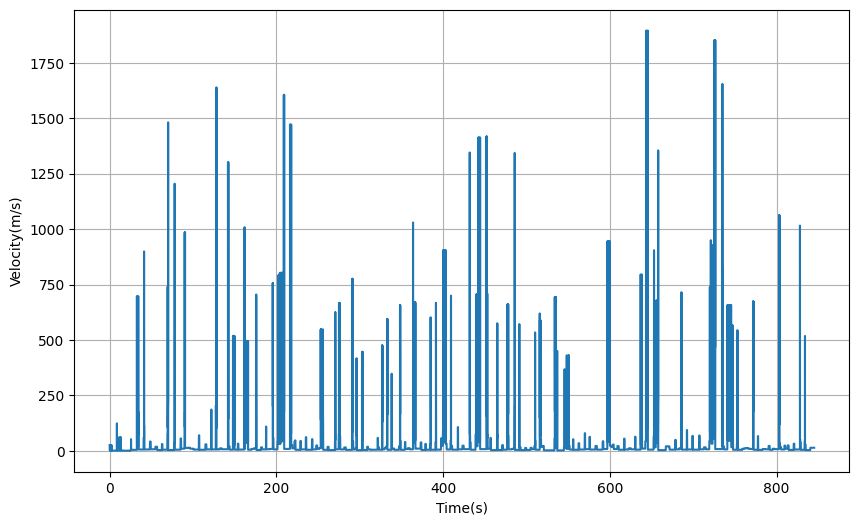

In [25]:
if DEBUG:
    plt.figure(figsize=(10,6))
    plt.plot(acc_data_cleaned['Time'], acc_data_cleaned['Velocity'])
#     plt.plot(acc_data_cleaned['Time'], acc_data_cleaned['Previous_velocity'])
#     plt.plot(acc_data_cleaned['Time'], acc_data_cleaned['Next_velocity'])
    plt.xlabel('Time(s)')
    plt.ylabel('Velocity(m/s)')
    plt.grid()

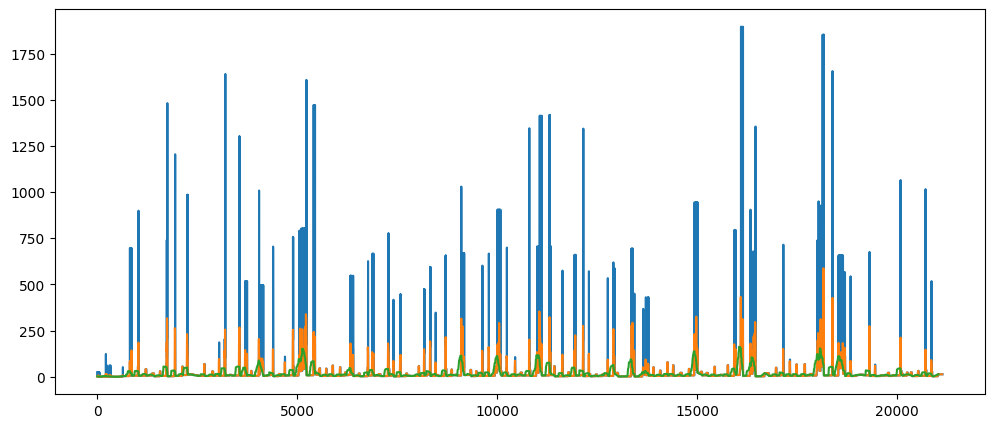

In [26]:
if DEBUG:
    vel = acc_data_cleaned['Velocity'].to_numpy()
    temp_100 = []
    for i in range(100,len(vel)):
        mean = np.mean(vel[i-100:i])
        temp_100.append(mean)
        
    temp_10 = []
    for i in range(10,len(vel)):
        mean = np.mean(vel[i-10:i])
        temp_10.append(mean)
    
    plt.figure(figsize=(12,5))
    plt.plot(vel)
    plt.plot(temp_10)
    plt.plot(temp_100)
    plt.show()
    
    

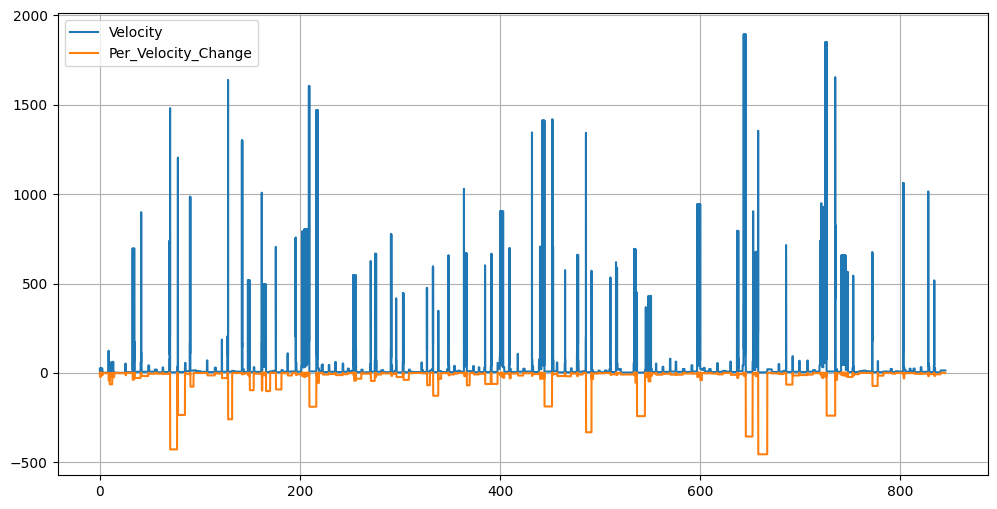

In [27]:
if DEBUG:
    plt.figure(figsize=(12,6))
    plt.plot(acc_data_cleaned['Time'], acc_data_cleaned['Velocity'])
    # plt.plot(acc_data_cleaned['Time'], acc_data_cleaned['Previous_velocity'])
    # plt.plot(acc_data_cleaned['Time'], acc_data_cleaned['Next_velocity'])
    plt.plot(acc_data_cleaned['Time'], acc_data_cleaned['Per_Vel_Chng'])
    plt.legend(['Velocity', 'Per_Velocity_Change'])
    plt.grid()

## ADDING  VELOCITY DATA TO ACC DATA 

#### Minor change might be needed
Ideally the labels sould be based on the logic if label_data_time[j]<acc_data_time[i] < label_data_time[j+1] then we shoul assign it with the label corr. to j that is what 2 does but given there is time diffrenece of 10 seconds the initial values should be asssigned a value NAN that is what mergeed_df_2 does 

In [28]:
acc_data_new.head()

,Time,x_acc,y_acc,z_acc
0,0.000000,-0.002651,0.020406,-0.118334
1,0.020001,-0.005269,0.022127,-0.098232
2,0.040002,-0.007887,0.023849,-0.078132
3,0.060003,-0.007887,0.023849,-0.078132
4,0.080003,-0.007887,0.023849,-0.078132


In [29]:
merged_df_1 = pd.merge_asof(acc_data_new, acc_data_cleaned[['Time', 'Velocity', 'Previous_velocity', 'Per_Vel_Chng', 'Next_velocity', 'Latitude', 'Longitude']], on='Time', direction='nearest')
# read the markdown
# merged_df_2 = pd.merge_asof(acc_data_new, label_data_cleaned[['Time', 'Label', 'velocity']], on='Time', direction='backward')
acc_data_new = merged_df_1
acc_data_new.head()

,Time,x_acc,y_acc,z_acc,Velocity,Previous_velocity,Per_Vel_Chng,Next_velocity,Latitude,Longitude
0,0.000000,-0.002651,0.020406,-0.118334,24.999614,0.000000,1.000000,1.102519,16.812339,73.507754
1,0.020001,-0.005269,0.022127,-0.098232,1.102519,24.999614,-21.675001,24.999614,16.812345,73.507747
2,0.040002,-0.007887,0.023849,-0.078132,1.102519,24.999614,-21.675001,24.999614,16.812345,73.507747
3,0.060003,-0.007887,0.023849,-0.078132,1.102519,24.999614,-21.675001,24.999614,16.812345,73.507747
4,0.080003,-0.007887,0.023849,-0.078132,1.102519,24.999614,-21.675001,24.999614,16.812345,73.507747


## ADDING LABEL TO ACC DATA

In [30]:
merged_df_2 = pd.merge_asof(acc_data_new, label_data_cleaned[['Time', 'Label']], on='Time', direction='nearest')
acc_data_new = merged_df_2
acc_data_new.head()

,Time,x_acc,y_acc,z_acc,Velocity,Previous_velocity,Per_Vel_Chng,Next_velocity,Latitude,Longitude,Label
0,0.000000,-0.002651,0.020406,-0.118334,24.999614,0.000000,1.000000,1.102519,16.812339,73.507754,1
1,0.020001,-0.005269,0.022127,-0.098232,1.102519,24.999614,-21.675001,24.999614,16.812345,73.507747,1
2,0.040002,-0.007887,0.023849,-0.078132,1.102519,24.999614,-21.675001,24.999614,16.812345,73.507747,1
3,0.060003,-0.007887,0.023849,-0.078132,1.102519,24.999614,-21.675001,24.999614,16.812345,73.507747,1
4,0.080003,-0.007887,0.023849,-0.078132,1.102519,24.999614,-21.675001,24.999614,16.812345,73.507747,1


## PLOTTING VEL RESAMPLED DATA AND LABELS

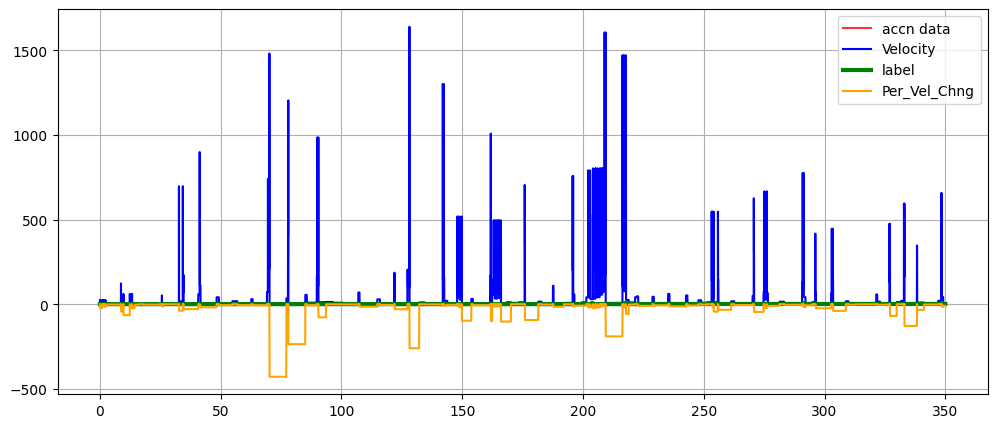

In [31]:
toi = (0,350)

plt.figure(figsize=(12,5))
plt.plot(acc_data_new['Time'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
         acc_data_new['x_acc'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
         label = 'accn data', color='r', alpha=0.8)

plt.plot(acc_data_new['Time'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
         acc_data_new['Velocity'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
         label = 'Velocity', color='b')

plt.plot(acc_data_new['Time'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
         acc_data_new['Label'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
         label = 'label', color='g', linewidth=3)

plt.plot(acc_data_new['Time'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
         acc_data_new['Per_Vel_Chng'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
         label = 'Per_Vel_Chng', color='orange')

plt.legend()
plt.grid()
plt.show()

## z acc vehicle vs velocity 

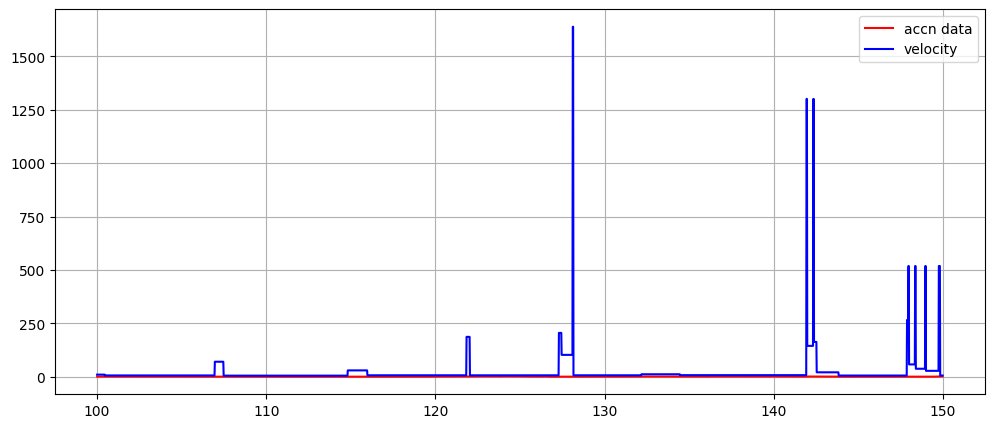

In [32]:
if DEBUG:
    toi = (100,150)

    plt.figure(figsize=(12,5))
    plt.plot(acc_data_new['Time'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
             acc_data_new['z_acc'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
             label = 'accn data', color='r')

    plt.plot(acc_data_new['Time'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
             acc_data_new['Velocity'][int(toi[0]*resampling_freq):int(toi[1]*resampling_freq)],
             label = 'velocity', color='b')

    plt.legend()
    plt.grid()
    plt.show()

# REORIENTATION 
## EULER ANGLE APPROACH 
rotating the data in a way that the y axis is perpendicular to the surface o the road the reorientation done is based on the maen value of the acceleration calculated in one second which could be changed by changing the tuning time variable 

In [35]:
ax = acc_data_new['x_acc'][:int(resampling_freq*tuning_time)].mean()
ay = acc_data_new['y_acc'][:int(resampling_freq*tuning_time)].mean()
az = acc_data_new['z_acc'][:int(resampling_freq*tuning_time)].mean()

alpha = np.arctan2(ay, az)
beta = np.arctan(-ax/np.sqrt(ay**2 + az**2))
rotation_matrix_alpha = np.array(
    [[1,0,0], 
    [0,np.cos(alpha), -np.sin(alpha)],
    [0, np.sin(alpha), np.cos(alpha)]]
)
rotation_matrix_beta = np.array(
    [[np.cos(beta), 0, np.sin(beta)],
    [0,1,0],
    [-np.sin(beta), 0, np.cos(beta)]]
)
rotation_matrix_1 = rotation_matrix_beta@rotation_matrix_alpha
rotated_1 = np.dot(rotation_matrix_1, np.array([ax, ay, az]))
gamma = np.arctan2(rotated_1[0], rotated_1[1])
rotation_matrix_gamma = np.array(
    [[np.cos(gamma), -np.sin(gamma), 0], 
    [np.sin(gamma), np.cos(gamma), 0], 
    [0, 0, 1]]
)
rotation_matrix = rotation_matrix_gamma@rotation_matrix_1
data = acc_data_new[['x_acc', 'y_acc', 'z_acc']]
rotated_data = np.dot(rotation_matrix, np.array(data).T)
if DEBUG:
    print("Reoriented [ax, ay, az] =", rotated_data[:, :int(resampling_freq*tuning_time)].mean(axis=1))

Reoriented [ax, ay, az] = [-3.95083272e-18  3.04227130e-18  8.10060476e-02]


In [36]:
# theta =  -np.arccos(acc_data_new['y_acc'][:int(resampling_freq*tuning_time)].mean()/9.81)
# # rotation_matrix = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
# rotation_matrix = np.array([[1,0,0], [0,np.cos(theta), -np.sin(theta)],[0, np.sin(theta), np.cos(theta)]])
# data = acc_data_new[['x_acc', 'y_acc', 'z_acc']]
# rotated_data = np.dot(rotation_matrix, np.array(data).T)
# rotated_data[1][:int(resampling_freq*tuning_time)].mean()

### visualising data rotated using euler angle approach 

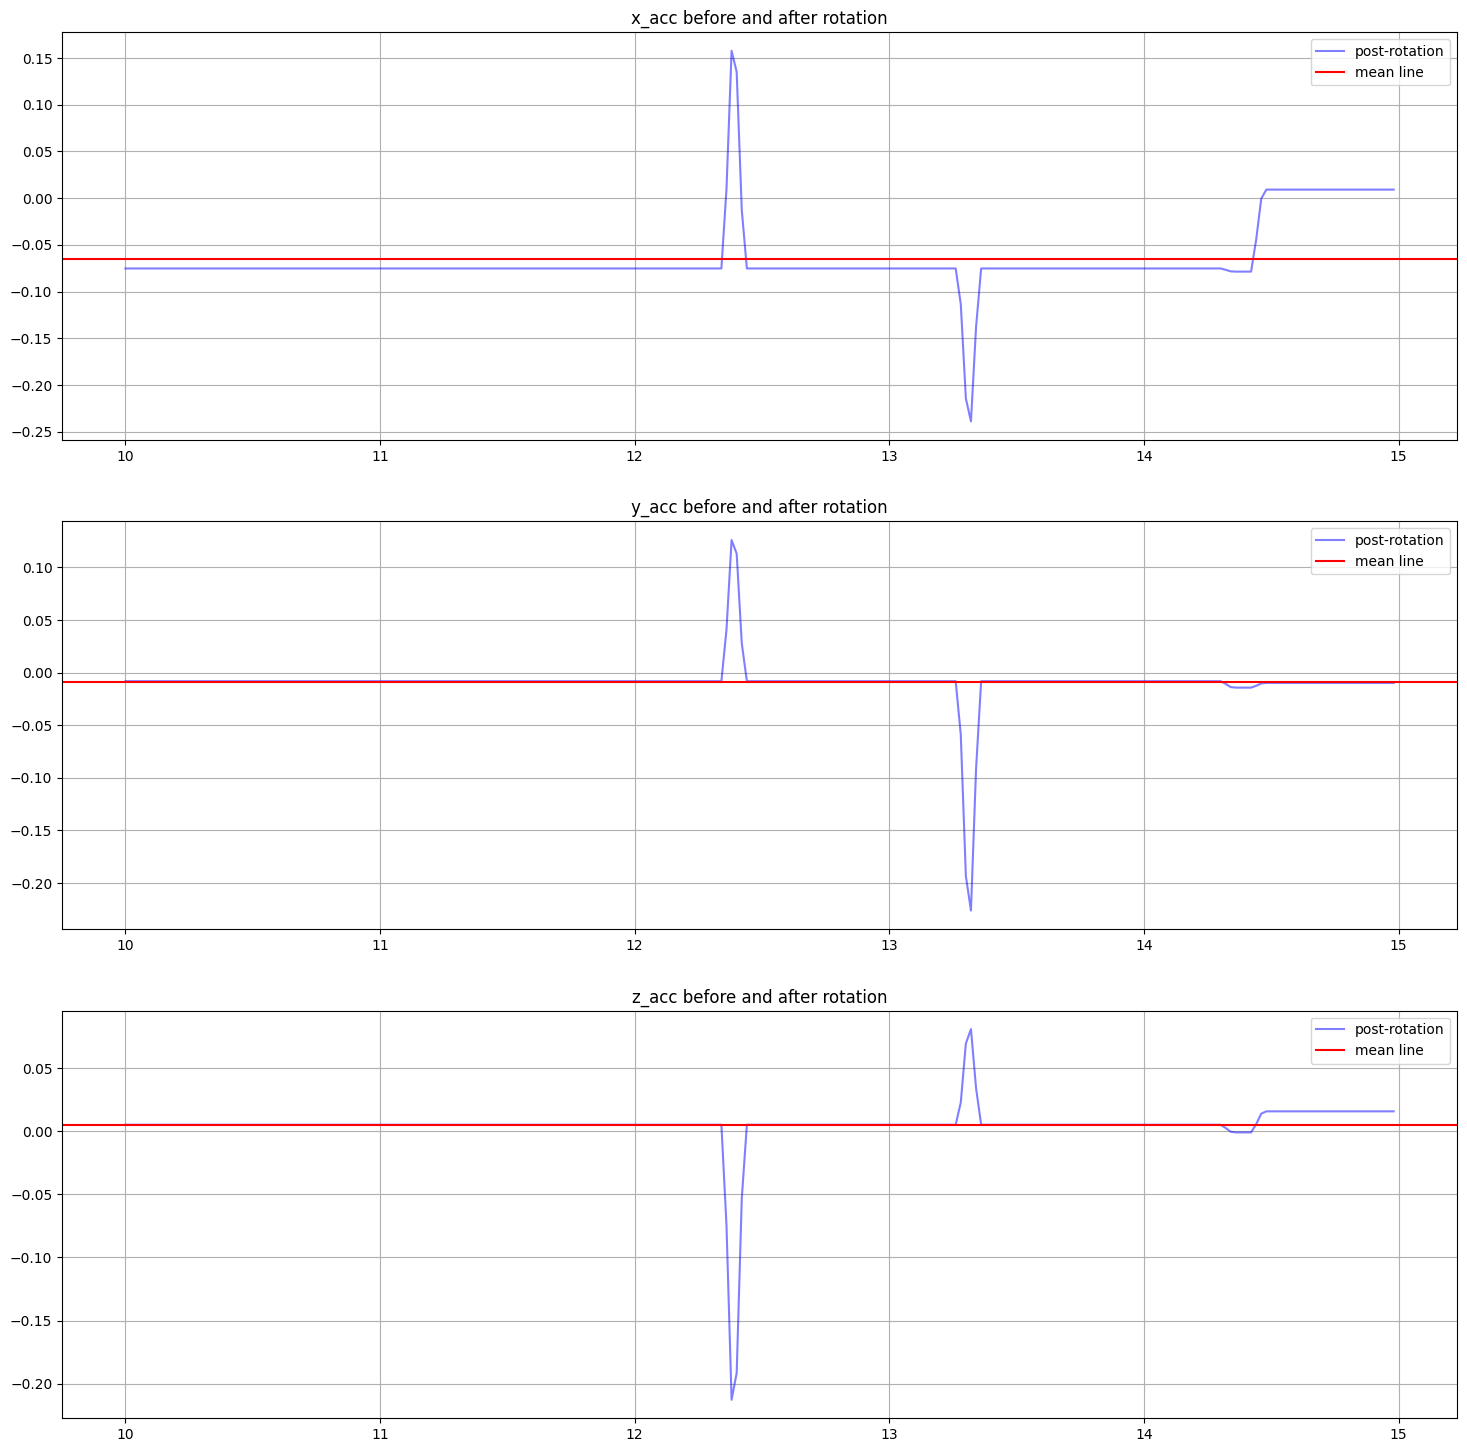

In [37]:
if DEBUG:
    time_of_intrest = (10,15) #time in seconds to see the complete data use 120
    x_acc_euler_data = rotated_data[0]
    y_acc_euler_data = rotated_data[1]
    z_acc_euler_data = rotated_data[2]

    fig,ax = plt.subplots(nrows = 3, ncols = 1, figsize=(18,18))
    ax[0].set_title('x_acc before and after rotation')
    ax[0].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               x_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               label='post-rotation', color = 'blue', alpha = 0.5)
    ax[0].axhline(x_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean(), label = 'mean line', color= 'red')
    ax[0].annotate(f'Mean: {x_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean():.2f}',
                   xy=(0.5,x_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean()), 
                   xytext=(0.5, x_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean() + 1))
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title('y_acc before and after rotation')
    ax[1].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
               y_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               label='post-rotation', color = 'blue', alpha = 0.5)
    ax[1].axhline(y_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean(), label = 'mean line', color= 'red')
    ax[1].annotate(f'Mean: {y_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean():.2f}', 
                   xy=(0.5,y_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean()), 
                   xytext=(0.5, y_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean() + 1))
    ax[1].legend()
    ax[1].grid()

    ax[2].set_title('z_acc before and after rotation')
    ax[2].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               z_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               label='post-rotation', color = 'blue', alpha = 0.5)
    ax[2].axhline(z_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean(), label = 'mean line', color= 'red')
    ax[2].annotate(f'Mean: {z_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean():.2f}', 
                   xy=(0.5,z_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean()), 
                   xytext=(0.5, z_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean() + 1))
    ax[2].legend()
    ax[2].grid()

    plt.show()

### visualising data points pre and post rotation on a 3-D plot 

In [38]:
if plot_3d:
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    time_of_intrest = 2 #for all the data points use 120
    ax.scatter(acc_data_new['x_acc'][:int(resampling_freq*time_of_intrest)], 
               acc_data_new['y_acc'][:int(resampling_freq*time_of_intrest)], 
               acc_data_new['z_acc'][:int(resampling_freq*time_of_intrest)], 
               marker='o', color = 'red', label='raw data')
    ax.scatter(rotated_data[0][:int(resampling_freq*time_of_intrest)],
               rotated_data[1][:int(resampling_freq*time_of_intrest)],
               rotated_data[2][:int(resampling_freq*time_of_intrest)], 
               marker = 'o', color = 'blue', label='euler angle reorientation')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('acc data points')
    ax.legend()
    plt.show()

## UNCENTERED PCA APPROACH
this approcah uses uncentered pca to come up with principal components which are treated as new axis for further analysis pca components are calculated by taking data specified in a range 

In [39]:
def PCA_transform(df):
    M = np.array(df[['x_acc', 'y_acc', 'z_acc']])
    MTM = np.matmul(M.T, M)
    egval, egvect = eigh(MTM)
    idx = egval.argsort()[::-1]
    egval = egval[idx]
    egvect = egvect[:, idx]
    return egvect

In [40]:
def get_data_for_pca(start,stop, df_input):
    data = {
    'x_acc' : df_input.loc[(df_input['Time'] > start) & (df_input['Time'] < stop), 'x_acc'],
    'y_acc' : df_input.loc[(df_input['Time'] > start) & (df_input['Time'] < stop), 'y_acc'],
    'z_acc' : df_input.loc[(df_input['Time'] > start) & (df_input['Time'] < stop), 'z_acc'],
    'seconds' : df_input.loc[(df_input['Time'] > start) & (df_input['Time'] < stop), 'Time']
    }
    df_pca = pd.DataFrame(data)
    return df_pca

### finding the principal components 

In [41]:
pca_df = get_data_for_pca(10,11,acc_data_new) #you can specify the start and end time in seconds 
egvect = PCA_transform(pca_df)
egvect
pc_1 = egvect[:][0]
pc_2 = egvect[:][1]
pc_3 = egvect[:][2]
pca_y_acc = np.dot(acc_data_new[['x_acc', 'y_acc', 'z_acc']].values, pc_1)
pca_x_acc = - np.dot(acc_data_new[['x_acc', 'y_acc', 'z_acc']].values, pc_2)
pca_z_acc = np.dot(acc_data_new[['x_acc', 'y_acc', 'z_acc']].values, pc_3)

### VISUALISING WHAT THE UNCETERED PCA FUNCTION IS DOING 

In [42]:
if plot_3d:
    %matplotlib notebook
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(acc_data_new['x_acc'][:250], acc_data_new['y_acc'][:250], acc_data_new['z_acc'][:250], marker='o')
    ax.quiver(0, 0, 0, pc_1[0], pc_1[1], pc_1[2], color='red', label='pc1')
    ax.quiver(0, 0, 0, pc_2[0], pc_2[1], pc_2[2], color='green', label='pc2')
    ax.quiver(0, 0, 0, pc_3[0], pc_3[1], pc_3[2], color='orange', label='pc3')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('principal components visualised')
    ax.legend()
    plt.show()
    %matplotlib inline

In [43]:
if plot_3d:
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    time_of_intrest = 2 #for all the data points use 120
    ax.scatter(acc_data_new['x_acc'][:int(resampling_freq*time_of_intrest)], 
               acc_data_new['y_acc'][:int(resampling_freq*time_of_intrest)], 
               acc_data_new['z_acc'][:int(resampling_freq*time_of_intrest)], 
               marker='o', color = 'red', label='raw data')
    ax.scatter(pca_x_acc[:int(resampling_freq*time_of_intrest)],
               pca_z_acc[:int(resampling_freq*time_of_intrest)],
               pca_y_acc[:int(resampling_freq*time_of_intrest)], 
               marker = 'o', color = 'blue', label='PCA reoriented data')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('acc data points')
    ax.legend()
    plt.show()

### visualising data oriented using pca approach 

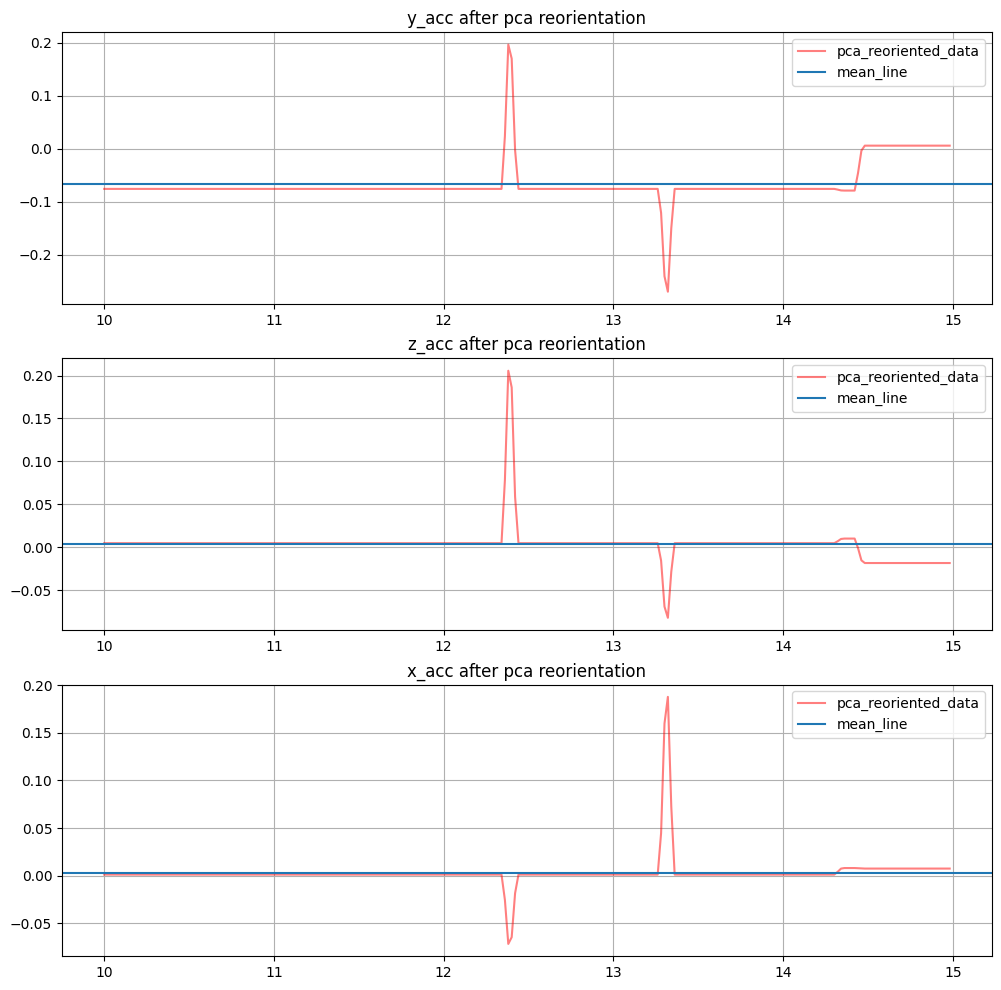

In [44]:
%matplotlib inline
if DEBUG:
    time_of_intrest = (10,15) #time in seconds to see complete figure use 120
    fig,ax = plt.subplots(ncols = 1, nrows=3, figsize = (12,12))

    ax[0].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
               pca_y_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               color = 'red', label = 'pca_reoriented_data',alpha = 0.5)
    ax[0].axhline(pca_y_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean(), label='mean_line')
    ax[0].legend()
    ax[0].set_title('y_acc after pca reorientation')
    ax[0].grid()

    ax[1].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               pca_z_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               color = 'red', label = 'pca_reoriented_data', alpha=0.5)
    ax[1].axhline(pca_z_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean(), label='mean_line')
    ax[1].legend()
    ax[1].set_title('z_acc after pca reorientation')
    ax[1].grid()

    ax[2].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
               pca_x_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               color = 'red', label = 'pca_reoriented_data', alpha= 0.5)
    ax[2].axhline(pca_x_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])].mean(), label='mean_line')
    ax[2].legend()
    ax[2].set_title('x_acc after pca reorientation')
    ax[2].grid()

    plt.show()

### PCA VS EULER ANGLE 

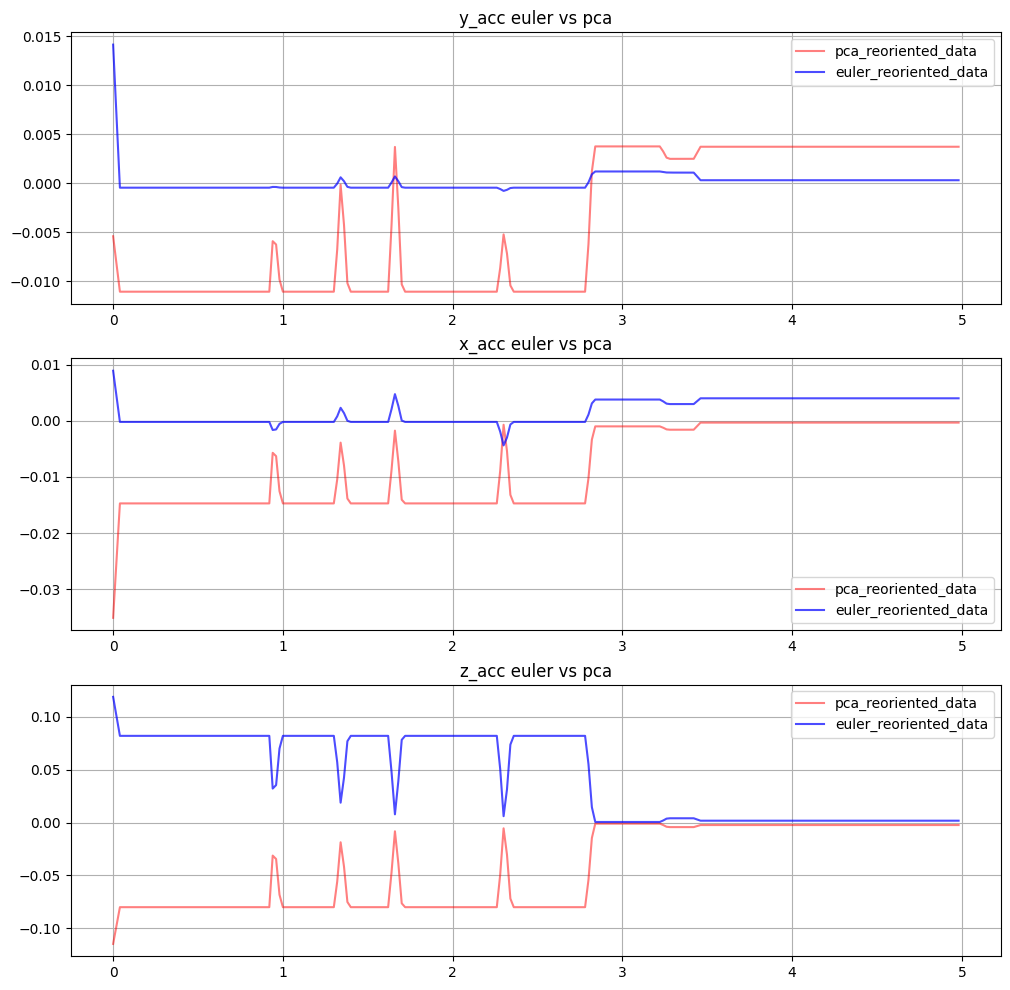

In [45]:
if DEBUG:
    time_of_intrest = (0,5) #time in seconds 
    fig,ax = plt.subplots(figsize = (12,12), nrows=3, ncols= 1)

    ax[0].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               pca_y_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               color = 'red', label = 'pca_reoriented_data',alpha = 0.5)
    ax[0].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               y_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               label='euler_reoriented_data', color = 'blue', alpha = 0.7)
    ax[0].legend()
    ax[0].set_title('y_acc euler vs pca')
    ax[0].grid()

    ax[1].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               pca_x_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               color = 'red', label = 'pca_reoriented_data',alpha = 0.5)
    ax[1].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               x_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               label='euler_reoriented_data', color = 'blue', alpha = 0.7)
    ax[1].legend()
    ax[1].set_title('x_acc euler vs pca')
    ax[1].grid()

    ax[2].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
               pca_z_acc[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
               color = 'red', label = 'pca_reoriented_data',alpha = 0.5)
    ax[2].plot(acc_data_new['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
               z_acc_euler_data[int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
               label='euler_reoriented_data', color = 'blue', alpha = 0.7)
    ax[2].legend()
    ax[2].set_title('z_acc euler vs pca')
    ax[2].grid()

    plt.show()

#### saving the pca and euler data

In [46]:
reoriented_data = {
    'Time' : acc_data_new['Time'],
    'x_acc_pca' : pca_x_acc,
    'y_acc_pca' : pca_y_acc,
    'z_acc_pca' : pca_z_acc,
    'x_acc_euler': rotated_data[0],
    'y_acc_euler': rotated_data[1],
    'z_acc_euler': rotated_data[2],
    'Label' : acc_data_new['Label'],
    'Latitude' : acc_data_new['Latitude'],
    'Longitude' : acc_data_new['Longitude'],
    'Velocity' : acc_data_new['Velocity'],
    'Previous_velocity': acc_data_new['Previous_velocity'],
    'Next_velocity': acc_data_new['Next_velocity'],
    'Per_Velocity_Chng': acc_data_new['Per_Vel_Chng'],
}
reoriented_df  = pd.DataFrame(reoriented_data)

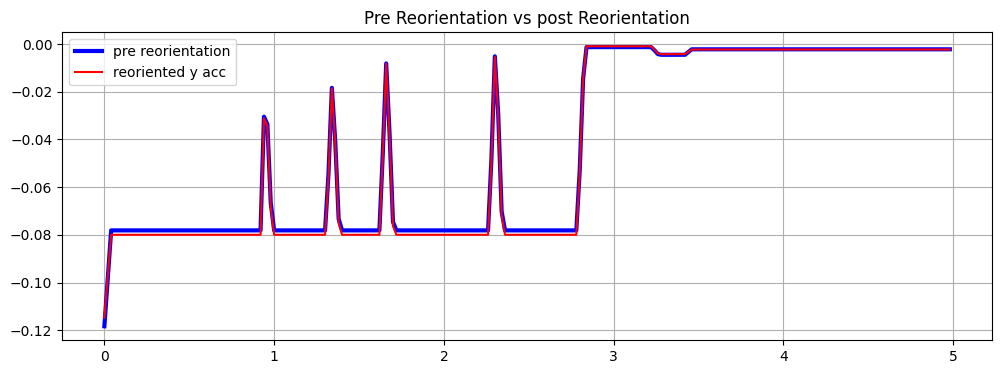

In [47]:
if DEBUG:
    time_of_interest = (0,5)
    plt.figure(figsize=(12,4))

    plt.plot(acc_data_new['Time'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)],
            acc_data_new['z_acc'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)],
            label='pre reorientation', color='blue', linewidth=3)
    plt.plot(reoriented_data['Time'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)],
            reoriented_data['z_acc_pca'][int(time_of_interest[0]*resampling_freq):int(time_of_interest[1]*resampling_freq)],
             label='reoriented y acc', color='red')
    # plt.plot(label_data_cleaned[(label_data_cleaned['Time'] < time_of_interest[1]) & (label_data_cleaned['Time'] > time_of_interest[0])]['Time'], 
    #            label_data_cleaned[(label_data_cleaned['Time'] < time_of_interest[1]) & (label_data_cleaned['Time'] > time_of_interest[0])]['Label'],
    #            label='labels', color='green')

    plt.legend()
    plt.grid()
    plt.title('Pre Reorientation vs post Reorientation')

    plt.plot()

# FILTERING 

In [48]:
def apply_custom_filter(filter_name, sig):
    path = os.path.join(path_to_filters, filter_name)
    data = np.load(path)
    b,a = data['ba'][0], data['ba'][1]
    w, h = signal.freqz(b,a)
    return signal.filtfilt(b, a, sig)

In [49]:
def butter_highpass_filter(data, sampling_freq, cutoff_freq, order=11):
    if cutoff_freq == 0:
        return data
    nyquist_freq = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq/nyquist_freq
    b,a = butter(order, normal_cutoff, 'high')
    y = filtfilt(b,a, np.array(data))
    return y

def butter_lowpass_filter(data, sampling_freq, cutoff_freq, order=11):
    nyquist_freq = 0.5 * sampling_freq
    normal_cutoff = cutoff_freq/nyquist_freq
    b,a = butter(order, normal_cutoff, 'low')
    y = filtfilt(b,a, np.array(data))
    return y

def butter_bandpass_filter(data, sampling_freq, low_cutoff, high_cutoff, order=11):
    nyquist = 0.5 * sampling_freq
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(order, [low, high], btype='bandpass')
    y = lfilter(b, a, data)
    return y

def butter_bandstop_filter(data, sampling_freq, low_cutoff, high_cutoff, order=11):
    nyquist = 0.5 * sampling_freq
    low = low_cutoff / nyquist
    high = high_cutoff/ nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    y = lfilter(b, a, data)
    return y

In [50]:
if filt_name_arr[0] == 'butter_orig':
    order = 11
    low_cutoff_freq = 4.0
    sampling_freq = 50
    high_cutoff_freq = 20.0

    for column in ['x_acc_pca', 'y_acc_pca', 'z_acc_pca', 'x_acc_euler', 'y_acc_euler', 'z_acc_euler']:
        #removing gravity and acc changes bcz of vehicles motion 
        reoriented_df[column + '_filtered_hp'] = butter_highpass_filter(
                                                    reoriented_df[column], 
                                                    sampling_freq, 
                                                    low_cutoff_freq)
        #gravity and acc bcz of motion of the vehicle 
        reoriented_df[column + '_filtered_lp'] = butter_lowpass_filter(
                                                    reoriented_df[column], 
                                                    sampling_freq, 
                                                    low_cutoff_freq)
        #data of intrest after removing low frequency events and sensor noise 
        reoriented_df[column + '_filtered_bp'] = butter_bandpass_filter(
                                                    reoriented_df[column], 
                                                    sampling_freq, 
                                                    1, 
                                                    8)
        # sensor noise data 
        reoriented_df[column + '_noise'] = butter_highpass_filter(
                                                reoriented_df[column], 
                                                sampling_freq, 
                                                high_cutoff_freq)
        # bandstop to remove auto noise 
        reoriented_df[column + '_filtered_bs'] = butter_bandstop_filter(
                                                    reoriented_df[column],
                                                    sampling_freq,
                                                    1,
                                                    2)
        
else:
    columns_to_filter = ['x_acc_pca', 'y_acc_pca', 'z_acc_pca', 'x_acc_euler', 'y_acc_euler', 'z_acc_euler']
    for column, filter_name in zip(columns_to_filter, filt_name_arr[1:]):
        reoriented_df[column + '_filter_' + filter_name] = apply_custom_filter(filter_name, reoriented_df[column])
    

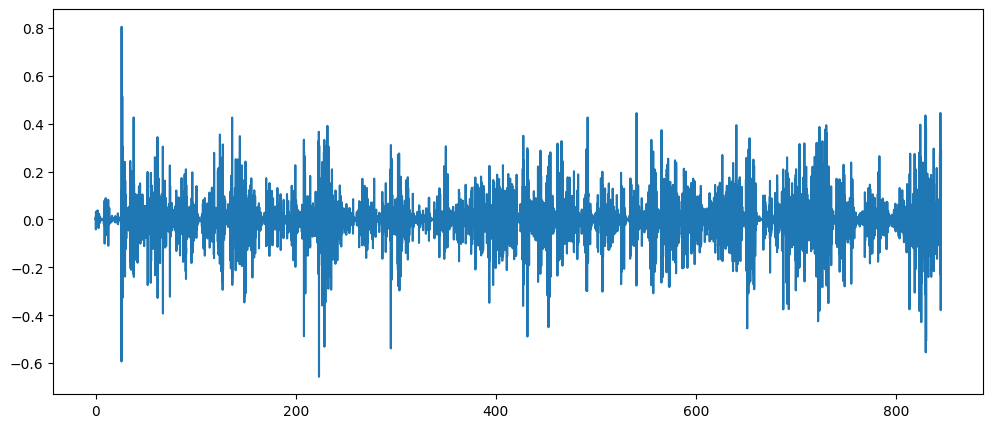

In [51]:
if DEBUG:
    plt.figure(figsize=(12,5))
    plt.plot(reoriented_df['Time'], reoriented_df['z_acc_euler_filtered_bp'])

### VISUALIZE ORIGINAL DATA VS POST FILTERING 

In [52]:
DEBUG = False

In [53]:
if DEBUG:
    toi = (0,10)
    if filt_name_arr[0] == 'butter_orig':
        fig,ax = plt.subplots(ncols = 1, nrows=3, figsize = (18,18))
        color = ['red', 'blue', 'orange', 'green', 'pink', 'yellow']
        for i in range(0,6):
            filtered_x = butter_highpass_filter(reoriented_df['x_acc_'+reorientation_type], sampling_freq, i)
            filtered_y = butter_highpass_filter(reoriented_df['y_acc_'+reorientation_type], sampling_freq, i)
            filtered_z = butter_highpass_filter(reoriented_df['z_acc_'+reorientation_type], sampling_freq, i)
            ax[0].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       filtered_x[int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       color = color[i-4], label = f'cutoff_freq_{i}')

            ax[1].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       filtered_y[int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       color = color[i-4], label = f'cutoff_freq_{i}')

            ax[2].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       filtered_z[int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       color = color[i-4], label = f'cutoff_freq_{i}')
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        ax[0].grid()
        ax[1].grid()
        ax[2].grid()
        ax[0].set_title('x_acc original vs filtered')
        ax[1].set_title('y_acc original vs filtered')
        ax[2].set_title('z_acc original vs filtered')
        plt.show()
    else:
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18,18))
        color = ['blue', 'orange', 'green', 'pink']
        for i, filter_name in enumerate(filt_name_arr):
            ax[0].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       reoriented_df['y_acc_' + reorientation_type + '_filter_' + filter_name][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       color = color[i], label = filter_name)

            ax[1].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       reoriented_df['x_acc_' + reorientation_type + '_filter_' + filter_name][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       color = color[i], label = filter_name)

            ax[2].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       reoriented_df['z_acc_' + reorientation_type + '_filter_' + filter_name][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                       color = color[i], label = filter_name)
        ax[0].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                   reoriented_df['y_acc_' + reorientation_type][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])],
                   color = 'red', label='original_data' )
        ax[1].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
               reoriented_df['x_acc_' + reorientation_type][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])],
               color = 'red', label='original_data' )
        ax[2].plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
               reoriented_df['z_acc_' + reorientation_type][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])],
               color = 'red', label='original_data' )
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        ax[0].grid()
        ax[1].grid()
        ax[2].grid()
        ax[0].set_title('y_acc original vs filtered')
        ax[1].set_title('x_acc original vs filtered')
        ax[2].set_title('z_acc original vs filtered')
        plt.show()


In [54]:
DEBUG = False

### visualising diffrent bands of butterworth

In [55]:
%matplotlib inline
if DEBUG:
    if filt_name_arr[0] == 'butter_orig':

        time_of_intrest = (10,15) #time in seconds for total band use 120
        fig,ax = plt.subplots(ncols = 1, nrows=3, figsize = (12,12))
        ax[0].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                    reoriented_df['y_acc_'+reorientation_type][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                    color = 'orange', label='original_data')
    #     ax[0].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
    #                reoriented_df['y_acc_'+reorientation_type+'_noise'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
    #                color='red', label = 'noise', alpha = 0.3)
        ax[0].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                   reoriented_df['y_acc_'+reorientation_type+'_filtered_lp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                   color='red', label = 'low_pass')
        # ax[0].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
        #             reoriented_df['y_acc_'+reorientation_type+'_filtered_hp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
        #             color='blue', label = 'highpass', alpha = 0.5 )
        # ax[0].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
        #            reoriented_df['y_acc_'+reorientation_type+'_filtered_bp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
        #            color='green', label = 'desired_freq_range')
        ax[0].legend()
        ax[0].grid()
        ax[0].set_title('z_acc pre and post filtering')

        ax[1].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                    reoriented_df['x_acc_'+reorientation_type][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                    color = 'orange', label='original_data')
    #     ax[1].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
    #                reoriented_df['x_acc_'+reorientation_type+'_noise'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
    #                color='red', label = 'noise', alpha = 0.3)
        ax[1].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                   reoriented_df['x_acc_'+reorientation_type+'_filtered_lp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                   color='red', label = 'low_freq_events')
        ax[1].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                   reoriented_df['x_acc_'+reorientation_type+'_filtered_hp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                   color='blue', label = 'highpass', alpha = 0.5 )
        ax[1].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                   reoriented_df['x_acc_'+reorientation_type+'_filtered_bp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                   color='green', label = 'desired_freq_range')
        ax[1].legend()
        ax[1].set_title('x_acc accerleration')

        ax[2].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                      reoriented_df['z_acc_'+reorientation_type][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])]
                      , color = 'orange' , label='original_data' )
    #     ax[2].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
    #                reoriented_df['z_acc_'+reorientation_type+'_noise'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
    #                color='red', label = 'noise', alpha = 0.3)
        ax[2].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                   reoriented_df['z_acc_'+reorientation_type+'_filtered_lp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                   color='red', label = 'low_freq_events', alpha = 1)
        ax[2].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                   reoriented_df['z_acc_'+reorientation_type+'_filtered_hp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                   color='blue', label = 'low_freq_events_removed', alpha = 0.5 )
        ax[2].plot(reoriented_df['Time'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])], 
                   reoriented_df['z_acc_'+reorientation_type+'_filtered_bp'][int(resampling_freq*time_of_intrest[0]):int(resampling_freq*time_of_intrest[1])],
                   color='green', label = 'desired_freq_range')
        ax[2].legend()
        ax[2].set_title('z_acc accerleration')
        plt.show()

### VISUALISING LABEL VS FILTERED DATA

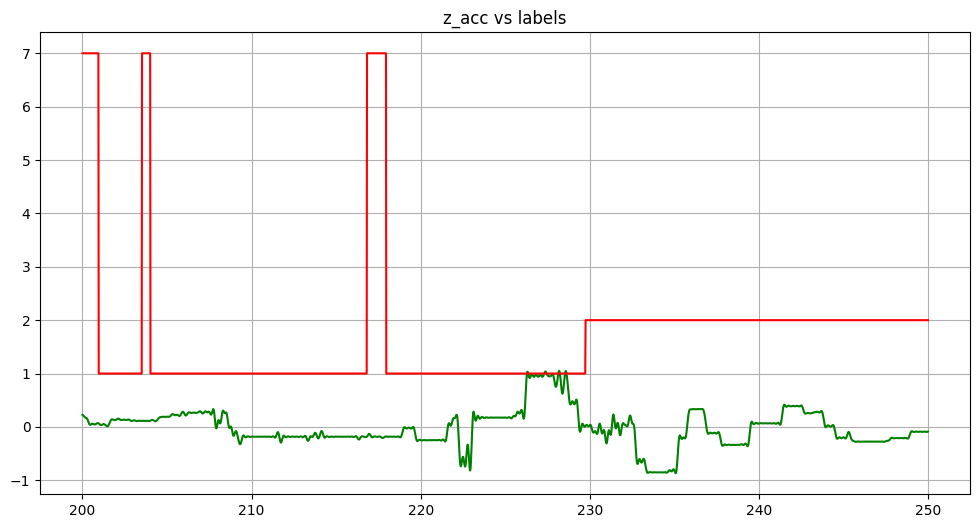

In [56]:
toi = (200,250)
plt.figure(figsize=(12,6))
if filt_name_arr[0] == 'butter_orig':
    plt.plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
           reoriented_df['z_acc_'+reorientation_type+'_filtered_lp'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])],
           color='green', label = 'desired_freq_range')
else:
    color = ['blue', 'orange', 'pink', 'yellow']
    for i, filter_name in enumerate(filt_name_arr): 
        plt.plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                   reoriented_df['z_acc_' + reorientation_type + '_filter_' + filter_name][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])], 
                   color = color[i], label = filter_name)

plt.plot(reoriented_df['Time'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])],
        reoriented_df['Label'][int(resampling_freq*toi[0]):int(resampling_freq*toi[1])],
        color = 'red')

plt.title('z_acc vs labels')
plt.grid()
plt.show()

In [57]:
selected_columns = ['Time', 'Label', 'Latitude', 'Longitude','Velocity','Previous_velocity','Next_velocity', 'Per_Velocity_Chng',
       'x_acc_pca_filtered_hp', 'x_acc_pca_filtered_lp', 'x_acc_pca_filtered_bs',
       'x_acc_pca_filtered_bp', 'y_acc_pca_filtered_hp', 'y_acc_pca_filtered_bs',
       'y_acc_pca_filtered_lp', 'y_acc_pca_filtered_bp', 'z_acc_pca_filtered_bs',
       'z_acc_pca_filtered_hp', 'z_acc_pca_filtered_lp', 'x_acc_euler_filtered_bs',
       'z_acc_pca_filtered_bp', 'x_acc_euler_filtered_hp', 'y_acc_euler_filtered_bs',
       'x_acc_euler_filtered_lp', 'x_acc_euler_filtered_bp', 'z_acc_euler_filtered_bs',
       'y_acc_euler_filtered_hp', 'y_acc_euler_filtered_lp',
       'y_acc_euler_filtered_bp', 'z_acc_euler_filtered_hp',
       'z_acc_euler_filtered_lp', 'z_acc_euler_filtered_bp', 'x_acc_pca_noise',
       'y_acc_pca_noise', 'z_acc_pca_noise', 'x_acc_euler_noise',
       'y_acc_euler_noise', 'z_acc_euler_noise']
filtered_df = reoriented_df[selected_columns]

In [58]:
if event_based_analysis:
    filtered_df.loc[filtered_df['Label']!=7, 'Label'] = 0

## LABELING 
We will be labeling data using sliding window the size of the sliding window can be changed in order to identify diffrent features of road quality 

In [59]:
class SlidingWindow:
    def __init__(self,window_size, overlap, x, y, z):
        
        self.window_size = window_size
        self.overlap = overlap
        self.create_windows(x, y, z)
    
    def create_windows(self, x, y, z):
        x_windows = []
        y_windows = []
        z_windows = []
        for i in range(0, len(x)-self.window_size, int(self.window_size*(1-self.overlap))):
            x_windows.append(x[i:i+self.window_size])
            y_windows.append(y[i:i+self.window_size])
            z_windows.append(z[i:i+self.window_size])
        self.x_windows = np.array(x_windows)
        self.y_windows = np.array(y_windows)
        self.z_windows = np.array(z_windows)
    
    def add_labels(self, label_data):
        labels = []
        for i in range(0, len(label_data)-self.window_size, int(self.window_size*(1-self.overlap))):
            window_slice = label_data['Label'].iloc[i:i+self.window_size]
            max_label = max(window_slice) 
            labels.append(max_label)
            
        self.labels = np.array(labels)
    
    def add_lat_long_windows(self,lat_long_data):
        lat_windows=[]
        long_windows=[]
        for i in range(0, len(lat_long_data)-self.window_size, int(self.window_size*(1-self.overlap))):
            lat_windows.append(lat_long_data['Latitude'][i])
            long_windows.append(lat_long_data['Longitude'][i])

        self.latitude = np.array(lat_windows)
        self.longitude = np.array(long_windows)
        
    def add_avg_velocity(self, vel_data):
        vel_window = []
        vel_prev_window=[]
        vel_next_window=[]
        per_vel_chng_window=[]
        for i in range(0, len(vel_data)-self.window_size, int(self.window_size*(1-self.overlap))):
            vel_window.append(np.mean(vel_data['Velocity'][i: i+self.window_size]))
            vel_prev_window.append(np.mean(vel_data['Previous_velocity'][i: i+self.window_size]))
            vel_next_window.append(np.mean(vel_data['Next_velocity'][i: i+self.window_size]))
            per_vel_chng_window.append(np.mean(vel_data['Per_Velocity_Chng'][i: i+self.window_size]))
        
        self.avg_vel = np.array(vel_window)
        self.prev_avg_vel = np.array(vel_prev_window)
        self.next_avg_vel = np.array(vel_next_window)
        self.per_vel_chng = np.array(per_vel_chng_window)
            

## Initialising a window 

In [60]:
x = filtered_df[f'x_acc_{reorientation_type}_filtered_lp']
y = filtered_df[f'y_acc_{reorientation_type}_filtered_lp']
z = filtered_df[f'z_acc_{reorientation_type}_filtered_lp']
roughness_window = SlidingWindow(100, 0.5,x, y, z)

### adding labels, lat, long and velocity to window
the labels assigned are based on mode

In [61]:
roughness_window.add_labels(filtered_df)
roughness_window.add_lat_long_windows(filtered_df)
roughness_window.add_avg_velocity(filtered_df)
if DEBUG:
    roughness_window.labels

## DEFINING A NEW DATAFRAME TO BE USED FOR TRAINING 

In [62]:
training_df = pd.DataFrame({
    'x_acc': list(roughness_window.x_windows),
    'y_acc': list(roughness_window.y_windows),
    'z_acc': list(roughness_window.z_windows),
    'Longitude': roughness_window.longitude,
    'Latitude': roughness_window.latitude,
    'Velocity': roughness_window.avg_vel,
    'Previous_velocity': roughness_window.prev_avg_vel,
    'Next_velocity': roughness_window.next_avg_vel,
    'Per_Velocity_Chng': roughness_window.per_vel_chng,
    'Label': roughness_window.labels 
})
training_df.head()

,x_acc,y_acc,z_acc,Longitude,Latitude,Velocity,Previous_velocity,Next_velocity,Per_Velocity_Chng,Label
0,"[0.00891040594001461, 0.006168608560938028, 0....","[0.01414882430966186, 0.00975847840029539, 0.0...","[0.11907156419701766, 0.10796895517018695, 0.0...",73.507754,16.812339,3.513692,23.399554,23.421750,-14.272497,1
1,"[-0.0005375726694549276, -0.000403505361299335...","[-0.0003384574158415309, -0.000333201206741191...","[0.06801597623394597, 0.07046565177929603, 0.0...",73.507747,16.812345,3.550065,21.597089,26.732092,-9.130869,1
2,"[-0.00024837187861187233, -0.00028080938446326...","[-0.0004262700870895882, -0.000436080823507938...","[0.07780788518254625, 0.07906143067454319, 0.0...",73.507747,16.812345,1.741415,11.004585,76.985744,-5.611684,1
3,"[0.003796745600514908, 0.003682594659027145, 0...","[0.0012190269320779662, 0.0011848106721076346,...","[0.0009552764800487509, 0.0028890497993032237,...",73.507739,16.812351,0.839612,2.070362,123.716759,-1.465857,1
4,"[0.004000437040909902, 0.004002957168511739, 0...","[0.00032237053435742267, 0.0003164597393620724...","[0.0018074588884526115, 0.00184751646513456, 0...",73.507739,16.812351,0.839612,2.070362,123.716759,-1.465857,1


# FEATURE EXTRACTION 

## TIME DOMAIN 

In [63]:
def ten_pt_avg(data, method = 'ISO'):
    sorted_data = np.sort(data.flatten())
    if method == 'ISO':
        tpa_iso = (np.sum(sorted_data[::-1][0:5]) - np.sum(sorted_data[0:5]))/5 #ask if it should be 5 or 50 
        return tpa_iso
    if method == 'DIN':
        tpa_din = (np.sum(sorted_data[::-1][0:5]) + np.sum(sorted_data[0:5]))/10
        return tpa_din
    else:
        print("wrong method")
        return None 

def peak_to_peak(data):
    sorted_data = np.sort(data.flatten())
    return sorted_data[-1] - sorted_data[0]

In [64]:
# acc_values = []
# for i in range(138, 147):
#     acc_values=(training_df['y_acc'][i])
#     print(training_df['Label'][i])
#     plot_fft(acc_values, 50)

In [65]:
#rms values
training_df['x_rms'] = training_df['x_acc'].apply(lambda x: np.sqrt(np.mean(x**2)))
training_df['y_rms'] = training_df['y_acc'].apply(lambda x: np.sqrt(np.mean(x**2)))
training_df['z_rms'] = training_df['z_acc'].apply(lambda x: np.sqrt(np.mean(x**2)))

#maximum value
training_df['x_max'] = training_df['x_acc'].apply(lambda x: np.max(x))
training_df['y_max'] = training_df['y_acc'].apply(lambda x: np.max(x))
training_df['z_max'] = training_df['z_acc'].apply(lambda x: np.max(x))

#minimum value
training_df['x_min'] = training_df['x_acc'].apply(lambda x: np.min(x))
training_df['y_min'] = training_df['y_acc'].apply(lambda x: np.min(x))
training_df['z_min'] = training_df['z_acc'].apply(lambda x: np.min(x))

# mean value 
training_df['x_mean'] = training_df['x_acc'].apply(lambda x: np.mean(x))
training_df['y_mean'] = training_df['y_acc'].apply(lambda x: np.mean(x))
training_df['z_mean'] = training_df['z_acc'].apply(lambda x: np.mean(x))

# ten point average height (ISO)
training_df['x_tpah'] = training_df['x_acc'].apply(lambda x: ten_pt_avg(x))
training_df['y_tpah'] = training_df['y_acc'].apply(lambda x: ten_pt_avg(x))
training_df['z_tpah'] = training_df['z_acc'].apply(lambda x: ten_pt_avg(x))

# peak to peak
training_df['x_p2p'] = training_df['x_acc'].apply(lambda x: peak_to_peak(x))
training_df['y_p2p'] = training_df['y_acc'].apply(lambda x: peak_to_peak(x))
training_df['z_p2p'] = training_df['z_acc'].apply(lambda x: peak_to_peak(x))


training_df.tail()

,x_acc,y_acc,z_acc,Longitude,Latitude,Velocity,Previous_velocity,Next_velocity,Per_Velocity_Chng,Label,...,z_min,x_mean,y_mean,z_mean,x_tpah,y_tpah,z_tpah,x_p2p,y_p2p,z_p2p
839,"[-0.7516238856224824, -0.7510735187835645, -0....","[0.10154284038772628, 0.10146341627446846, 0.1...","[-0.8140436329469897, -0.8135530903450651, -0....",73.479528,16.771321,6.939870,19.500250,8.746305,-4.901219,1,...,-0.834553,-0.412964,0.018038,-0.438207,0.625109,0.164894,0.795216,0.637374,0.171197,0.810724
840,"[-0.3539851765794216, -0.3538976728120513, -0....","[-0.049178310769634546, -0.04864657995997377, ...","[-0.4730928745437191, -0.47214671552954335, -0...",73.479528,16.771321,12.194738,6.037189,1.913254,-0.471332,1,...,-0.536992,0.085649,-0.058332,-0.109758,1.537881,0.278703,0.510593,1.570607,0.289550,0.521816
841,"[-0.14755638039623908, -0.14128391409887475, -...","[0.0017640936623812098, 0.0003550499283324262,...","[-0.05944161287880784, -0.0595256619170547, -0...",73.479503,16.771165,13.666101,0.883782,0.000000,0.769037,1,...,-0.060507,0.400082,-0.159958,0.040593,1.387225,0.278703,0.275850,1.426856,0.289550,0.281102
842,"[1.0891483366840655, 1.0692641236223275, 1.048...","[-0.24586266195309794, -0.24345833379570594, -...","[-0.022395168484897202, -0.020539477711995036,...",73.479478,16.771008,13.666101,0.000000,0.000000,0.769037,1,...,-0.614656,0.350723,-0.226241,0.032934,1.169200,0.180859,0.865107,1.201690,0.206165,0.891535
843,"[0.0244137284028656, 0.027441499146278303, 0.0...","[-0.19309839124161626, -0.19344510591276567, -...","[0.21279688447679354, 0.21169284040800135, 0.2...",73.479478,16.771008,13.666101,0.000000,0.000000,0.769037,1,...,-0.614656,0.160915,-0.049069,0.181416,0.840399,0.619422,1.253267,0.855313,0.796380,1.559233


## FREQUENCY DOMAIN

In [66]:
def get_fft_values(signal,f_s):
    """
    Parameters:
    - signal : input_signal
    - f_s : sampling frequency 
    
    Retruns:
    - f_values: freqeuncy values 
    - fft_values: corresponsing amplitude from the fft 
    """
    N = len(signal)
    f_values = rfftfreq(N, 1 / f_s)
    fft_values_ = rfft(signal)
    fft_values = 2/N * np.abs(fft_values_)
    return f_values, fft_values

In [67]:
def plot_fft(signal, f_s):
    """
    Parameters:
    - signal: input_signal
    -f_s: sampling_frequency
    
    Returns:
    - plots the fourier transform graph
    """
    f_values, fft_values = get_fft_values(signal, f_s)
#     print(fft_values)
    plt.figure(figsize=(10,5))
    print("Freq with Max Amp: ", f_values[np.argmax(fft_values[1:])], " with max_value: ", np.max(fft_values[1:]))
    plt.plot(f_values[1:], fft_values[1:])

In [68]:
if DEBUG:
    data = acc_data_new['z_acc'][0:500].to_numpy()
    plot_fft(data, 50)

## WAVELET DOMAIN

In [69]:
def plot_sub_band(data, wavelet, depth=3):
    a = data
    ca=[]
    cd=[]
    for i in range(depth):
        a,d = pywt.dwt(a, wavelet)
        ca.append(a.copy())
        cd.append(d.copy())

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None]*i
        rec_a.append(pywt.waverec(coeff_list, wavelet))

    for i, coeff in enumerate(cd):
        coeff_list = [coeff, None] + [None]*i
        rec_d.append(pywt.waverec(coeff_list, wavelet))

    fig = plt.figure(figsize=(10,12))
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y))
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y))
        ax.set_ylabel("D%d" % (i + 1))
    
    

In [70]:
if DEBUG:
    wavelet = 'coif1'
    data = filtered_df['z_acc_euler_filtered_lp'][3000:3500]
    plot_sub_band(data, wavelet, 5)

### VISUALISING LABEL AGAINST FEATURES 

#### defining features of intrest

In [71]:
feature_arr = ['rms', 'max', 'min', 'mean', 'tpah', 'p2p']

In [72]:
def plot_feature_vs_label(feature, data):
    feature_arr = [f'x_{feature}', f'y_{feature}', f'z_{feature}']
    label_colors = {1: 'green', 2: 'blue', 3: 'yellow', 4: 'orange', 5: 'red'}
    
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for label, color in label_colors.items():
        label_data = data[data['Label'] == label]
        ax.scatter(label_data[feature_arr[0]], label_data[feature_arr[1]], label_data[feature_arr[2]],
                   marker='o', color=color, label=f'label_{label}_pts')

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title(f'Label vs {feature}')
    ax.legend()
    plt.show()

#### visualising it in 3-d based on x,y,z values

In [73]:
if plot_3d:
    for feature in feature_arr:
        plot_feature_vs_label(feature, training_df)

#### visualising it as a heatmap just based on y axis data

In [74]:
def plot_heatmap(feature, data):
    plt.figure(figsize = (7,5))
    plt.scatter(data.index, data['z_'+feature], c=data['Label'], cmap='plasma', marker='o', s=4)
    cbar = plt.colorbar()
    cbar.set_label('Label')
    plt.title(f'{feature} vs label heatmap')
    plt.show()

In [75]:
%matplotlib inline
if plot_hm:
    for feature in feature_arr:
        plot_heatmap(feature, training_df)

#### visualising feature vs label in a normal graph to look for pattern

In [76]:
def plot_label_vs_feature(feature, data, toi, velocity=False, mv=False, size=3):
    plt.figure(figsize=(12,4))
#     temp = np.array(training_df['y_acc'][toi[0]:toi[1]])
#     print(temp)
#     time = np.linspace(0, toi[1] - toi[0], (toi[1]-toi[0])*50)
    temp = data['z_'+feature][toi[0]:toi[1]].to_numpy()
    mv = [np.mean(temp[i-size:i]) for i in range(size, len(temp))]
    mv = [0]*size + mv

    # plt.plot(data.index[toi[0]:toi[1]], mv, color='b', label='ma of rms')
    # plt.plot(data.index[toi[0]:toi[1]], data['y_'+feature][toi[0]:toi[1]]-8.8, color = 'g', label=feature)
    plt.plot(data.index[toi[0]:toi[1]], data['Label'][toi[0]:toi[1]], color = 'r', label='Label')
    if velocity:
        plt.plot(data.index[toi[0]:toi[1]], data['Velocity'][toi[0]:toi[1]], color='b', label='velocity')
#         plt.plot(data.index[toi[0]:toi[1]], data['Per_Velocity_Chng'][toi[0]:toi[1]], color='orange', label='per_velocity_chng')
# #         plt.plot(data.index[toi[0]:toi[1]], data['Previous_velocity'][toi[0]:toi[1]], color='g', label='prev_velocity')
#         plt.plot(data.index[toi[0]:toi[1]], data['Next_velocity'][toi[0]:toi[1]], color='orange', label='next_velocity')
#     plt.scatter(data.index[toi[0]:toi[1]], data['y_'+feature][toi[0]:toi[1]], color='black')
    plt.legend()
    # plt.title(f'{feature}_vs_Label')
    plt.title('velocity vs label')
    plt.grid()
    plt.show()

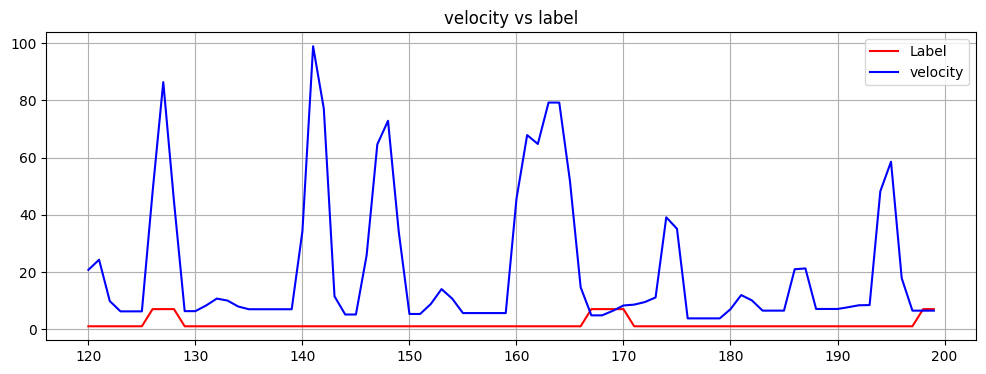

In [77]:
toi=(120, 200)
specific_feature = 'p2p'
if specific_feature:
    plot_label_vs_feature(specific_feature, training_df, toi, velocity=True)
else:
    for feature in feature_arr:
        plot_label_vs_feature(feature, training_df, toi)
    

## INVERTING DATA ABOUT MEAN

In [78]:
if DEBUG:
    toi=(80,340)
    time = acc_data_new['Time'][toi[0]*50:toi[1]*50].to_numpy()
    data = acc_data_new['x_acc'][toi[0]*50:toi[1]*50].to_numpy()
    acc = data - np.mean(data)
    acc = [value if value > 0 else 0 for value in acc]
    temp = [np.mean(acc[i:i+100])for i in range(len(acc)-10)]
    temp = [0]*10 + temp
    plt.figure(figsize=(12,5))
    plt.plot(time, acc, alpha=0.7)
    plt.plot(time, acc_data_new['Label'][toi[0]*50:toi[1]*50].to_numpy())
    plt.plot(time, temp)

## EXTRPOLATED RMS

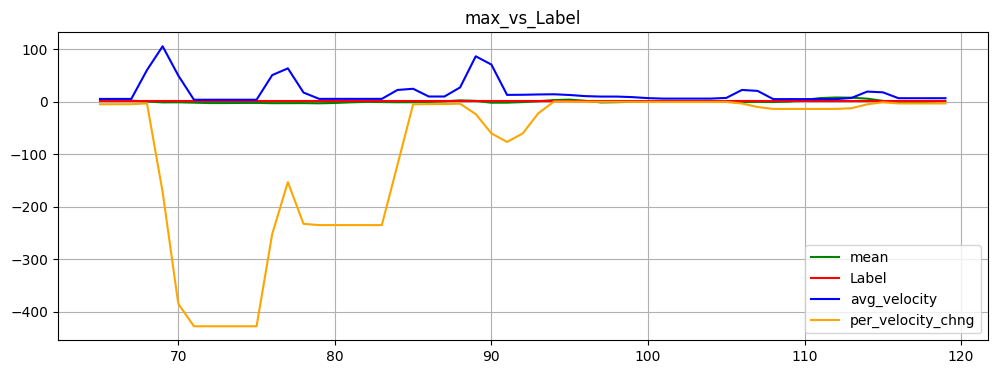

In [79]:
if not event_based_analysis:
    toi=(65,120)
    scaling_factor = 20
    rms_val = training_df['z_rms'][toi[0]:toi[1]]
    rms_val = rms_val - np.mean(rms_val)
    rms_val = rms_val * scaling_factor
    plt.figure(figsize=(12,4))
    # plt.plot(filtered_df['Time'][toi[0]*50: toi[1]*50], filtered_df[f'y_acc_{reorientation_type}_filtered_lp'][toi[0]*50:toi[1]*50])
    # plt.plot(filtered_df['Time'][toi[0]*50: toi[1]*50], filtered_df[f'z_acc_{reorientation_type}_filtered_lp'][toi[0]*50:toi[1]*50])
    plt.plot(training_df.index[toi[0]:toi[1]], rms_val, color = 'g', label='mean')
    plt.plot(training_df.index[toi[0]:toi[1]], training_df['Label'][toi[0]:toi[1]], color = 'r', label='Label')
    plt.plot(training_df.index[toi[0]:toi[1]], training_df['Velocity'][toi[0]:toi[1]], color='b', label='avg_velocity')
    plt.plot(training_df.index[toi[0]:toi[1]], training_df['Per_Velocity_Chng'][toi[0]:toi[1]], color='orange', label='per_velocity_chng')
    # plt.scatter(data.index[toi[0]:toi[1]], data['y_'+feature][toi[0]:toi[1]], color='black')
    plt.legend()
    plt.title(f'max_vs_Label')
    plt.grid()
    plt.show()

# CREATING AND TRAINING MODELS

In [80]:
def plot_actual_vs_predicted(Y_actual, Y_pred):
    x = np.linspace(0, len(Y_actual), len(Y_actual))
    plt.figure(figsize=(12,5))
    plt.plot(x, Y_actual, color='g', label='actual')
    plt.plot(x, Y_pred, color='r', label='predicted')
    plt.title('ACTUAL VS PREDICTED LABELS')
    plt.grid()
    plt.legend()
    plt.show()
    

In [81]:
# import joblib
# features = ['Velocity', 'y_max', 'y_min','y_p2p', 'Previous_velocity', 'Next_velocity']
# X = training_df[features]
# Y = training_df['Label']

# model = joblib.load('random_forest_event.pkl')

# Y_pred_comp = model.predict(X)
# accuracy = accuracy_score(Y, Y_pred_comp)
# print(f'models accuracy on complete data when trained on all features is: {accuracy}')

# plot_actual_vs_predicted(Y, Y_pred_comp)

## RANDOM FOREST
### ONLY USING RMS AND VELOCITY

In [82]:
# features = ['y_p2p']
features = ['z_p2p', 'Velocity', 'Previous_velocity', 'Next_velocity']

In [83]:
####### splitting the data #########
data_start = 0
X = training_df[features][data_start:400]
Y = training_df['Label'][data_start:400]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

######## creating a random forest classifier ########
rndm_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rndm_clf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [84]:
######## predicting accuracy ##########
Y_pred = rndm_clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'models accuracy on test data when trained using RMS and velocity data is: {accuracy}')

Y_pred_comp = rndm_clf.predict(X)
accuracy = accuracy_score(Y, Y_pred_comp)
print(f'models accuracy on complete data when trained using RMS and velocity data is: {accuracy}')

models accuracy on test data when trained using RMS and velocity data is: 0.675
models accuracy on complete data when trained using RMS and velocity data is: 0.645


#### plotting actual vs predicted results 

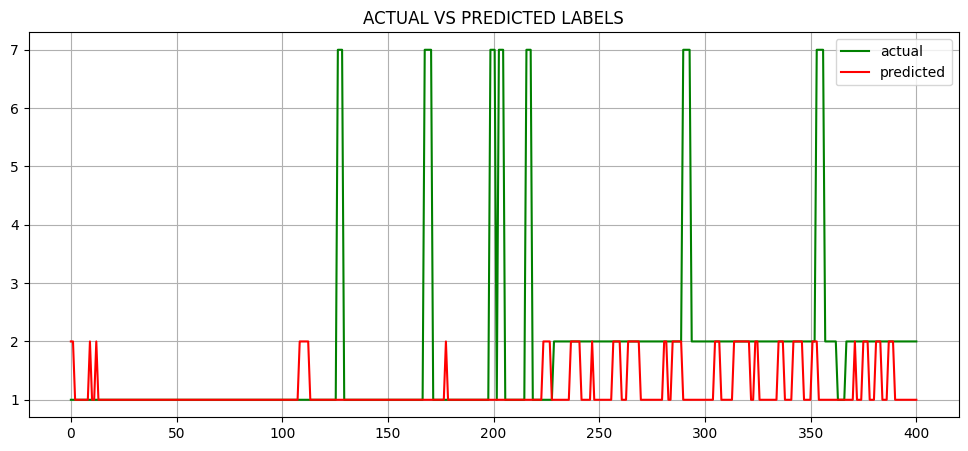

In [85]:
plot_actual_vs_predicted(Y, Y_pred_comp)

### ALL FEATURES

In [86]:
####### splitting the data #########
# features = ['y_rms', 'Velocity', 'Previous_velocity', 'Next_velocity']
features = ['z_rms', 'Velocity']
X = training_df[features]
Y = training_df['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

######## creating a random forest classifier ########
rndm_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rndm_clf.fit(X_train, Y_train)

# import joblib
# joblib.dump(rndm_clf, 'random_forest_event.pkl')

RandomForestClassifier(max_depth=2, random_state=0)

In [87]:
######## predicting accuracy ##########
Y_pred = rndm_clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'models accuracy on test data when trained on all featured is: {accuracy}')

Y_pred_comp = rndm_clf.predict(X)
accuracy = accuracy_score(Y, Y_pred_comp)
print(f'models accuracy on complete data when trained on all features is: {accuracy}')

models accuracy on test data when trained on all featured is: 0.6456692913385826
models accuracy on complete data when trained on all features is: 0.6706161137440758


#### plot actual vs predicted

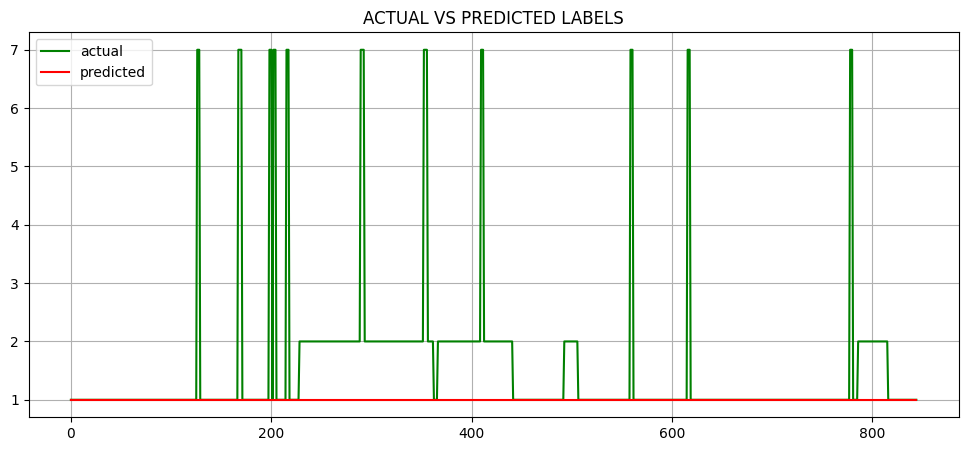

In [88]:
plot_actual_vs_predicted(Y, Y_pred_comp)

In [89]:
#Data generation required for label evaluation
# req_cols = ['z_rms', 'Velocity', 'Label']
# X_new = training_df[req_cols]
# for i in range(1, 8):
#     selected_rows = X_new.loc[X_new['Label'] == i]
#     data = selected_rows.reset_index(drop=True)
#     data.to_csv('../data/labels/'+date+'/'+'label_'+str(i)+'_with_'+'auto_'+str(data_num)+'_data.csv')

## SUPPORT VECTOR MACHINE
### training only on rms and velocity


In [90]:
features = ['z_p2p']

In [91]:
########### splitting the data ############
features = ['z_p2p', 'Velocity', 'Previous_velocity', 'Next_velocity']
X = training_df[features][0:400]
Y = training_df['Label'][0:400]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

############ training the model ############
C = 1.0
model = LinearSVC(C=C, max_iter=10000, dual=True,random_state = 0)
model.fit(X_train,Y_train)

/home/adwai04/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=True, max_iter=10000, random_state=0)

In [92]:
########### predicting scores ###########
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'models accuracy on test data when trained on rms and velocity data is: {accuracy}')

Y_pred_comp = model.predict(X)
accuracy = accuracy_score(Y, Y_pred_comp)
print(f'models accuracy on complete data when trained on rms and velocity data  is: {accuracy}')

models accuracy on test data when trained on rms and velocity data is: 0.4083333333333333
models accuracy on complete data when trained on rms and velocity data  is: 0.4425


#### plot actual vs predicted

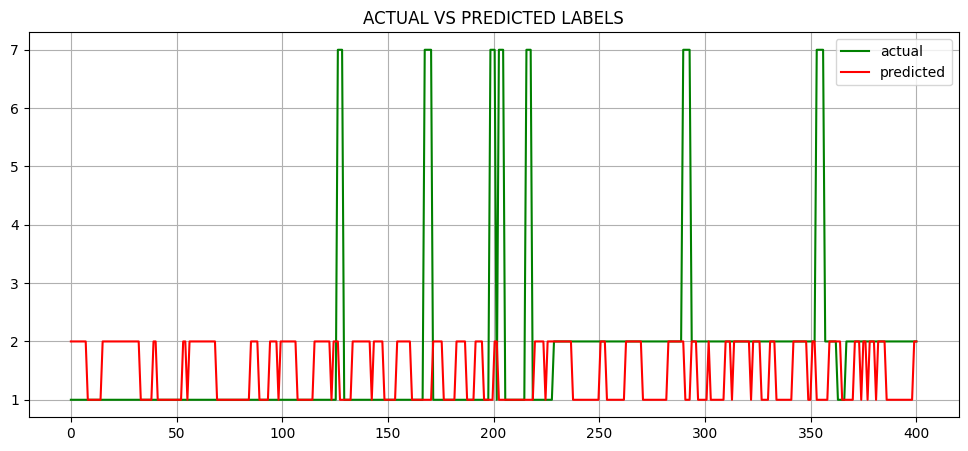

In [93]:
plot_actual_vs_predicted(Y, Y_pred_comp)

### TRAINING ON ALL POSSIBLE FEATURES 

In [94]:
########### splitting the data ############
features = ['z_rms']
X = training_df[features]
Y = training_df['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

############ training the model ############
C = 1.0
model = LinearSVC(C=C, max_iter=10000, dual=True,random_state = 0)
model.fit(X,Y)

LinearSVC(dual=True, max_iter=10000, random_state=0)

In [95]:
######## predicting accuracy ##########
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f'models accuracy on test data when trained on all featured is: {accuracy}')

Y_pred_comp = model.predict(X)
accuracy = accuracy_score(Y, Y_pred_comp)
print(f'models accuracy on complete data when trained on all features is: {accuracy}')

models accuracy on test data when trained on all featured is: 0.6456692913385826
models accuracy on complete data when trained on all features is: 0.6706161137440758


#### plotting actual vs predicted values 

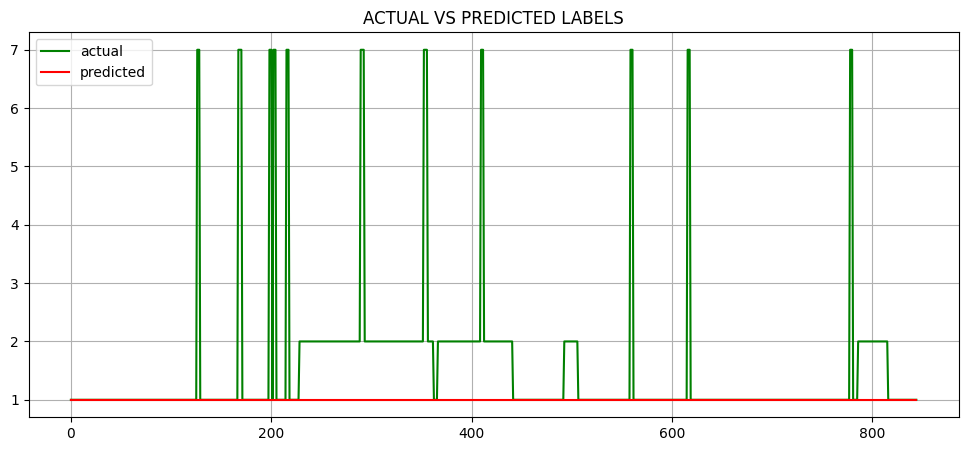

In [96]:
plot_actual_vs_predicted(Y, Y_pred_comp)

## AUTO NOISE

In [97]:
data_0 = pd.read_pickle('../data/acc_data/29March2024/pickledData/pickled_noise.pkl')
data_1 = pd.read_pickle('../data/acc_data/29March2024/pickledData/pickled1.pkl')
# data_2 = pd.read_pickle('../data/acc_data/28feb2024/pickledData/pickled2.pkl')

In [98]:
data_0 = fit_BPoly(data_0, 50)
data_1 = fit_BPoly(data_1 ,50)
x0 = data_0['x_acc'][0:1000].to_numpy()
x1 = data_1['x_acc'][3000:4000].to_numpy()
data_new = x1-x0


In [99]:
f_0, fft_0 = get_fft_values(data_0['x_acc'][0:1000].to_numpy(), 50)
f_1, fft_1 = get_fft_values(data_1['x_acc'][3000:4000].to_numpy(), 50)
f_2, fft_2 = get_fft_values(data_new, 50)

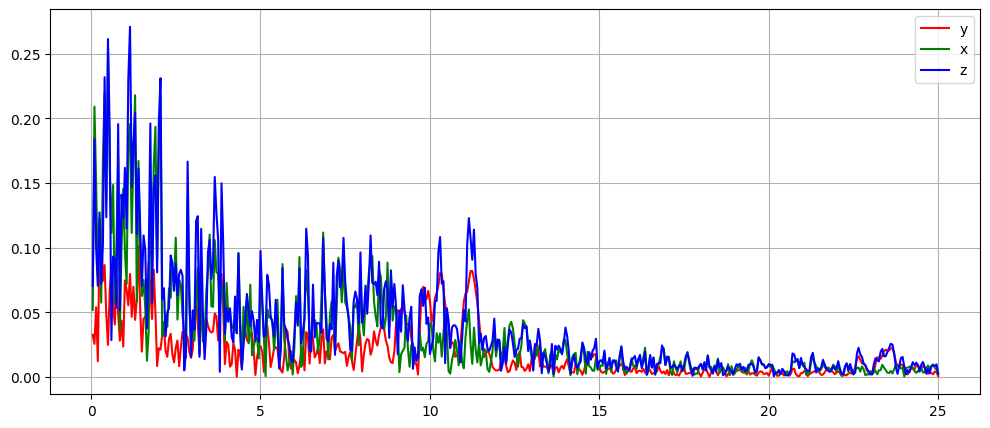

In [100]:
plt.figure(figsize=(12,5))
plt.plot(f_0[1:], fft_0[1:], color = 'red', label = 'y')
plt.plot(f_1[1:], fft_1[1:], color = 'green', label = 'x')
plt.plot(f_2[1:], fft_2[1:], color = 'blue', label = 'z')
plt.grid()
plt.legend()
plt.show()

## AMPLITUDE MODULATION 

In [101]:
modulation_frequency = 10
t = np.linspace(0,1, 500)
modulating_signal = np.sin(2 * np.pi * modulation_frequency * t) 
modulation_index = 0.4
modulated_signal = (1 + modulation_index * modulating_signal) * data_1['y_acc'][1000:1500]

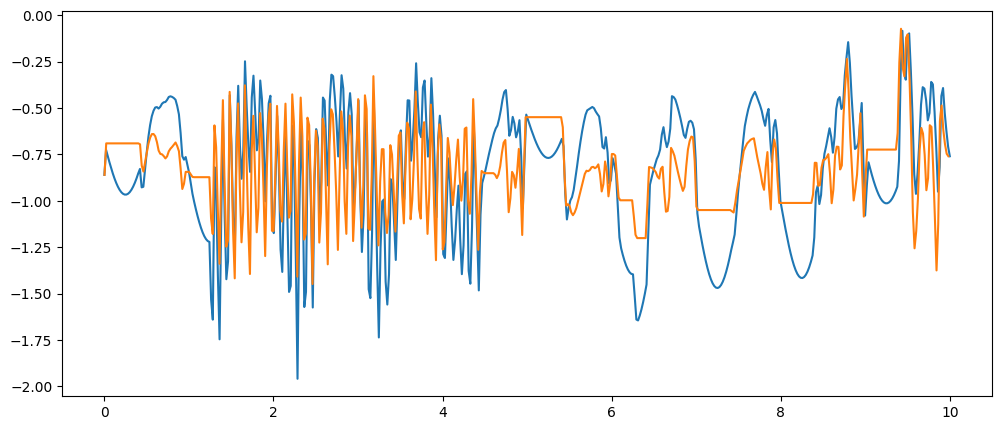

In [102]:
plt.figure(figsize=(12,5))
plt.plot(t*10, modulated_signal)
plt.plot(data_1['Time'][1000:1500]-20, data_1['y_acc'][1000:1500])

## WAVELET BASED FILTERING 

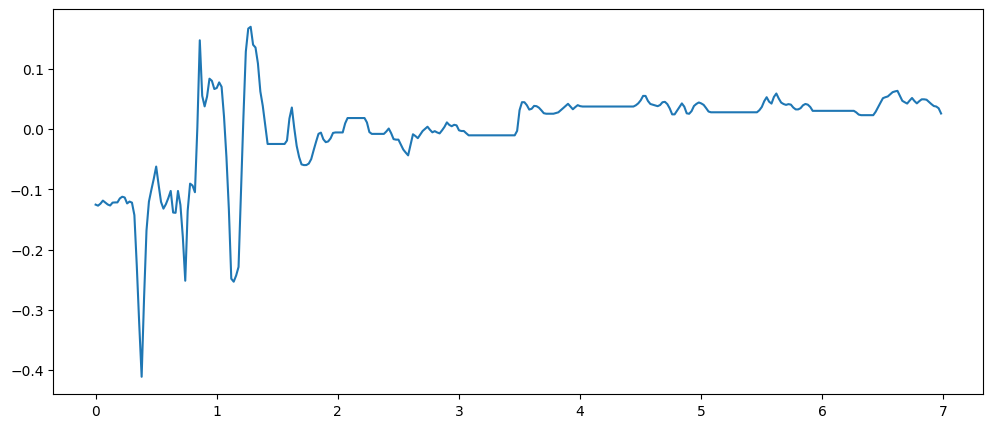

In [103]:
plt.figure(figsize=(12,5))
plt.plot(data_1['Time'][:350], data_1['y_acc'][:350] - np.mean(data_1['y_acc'][:350].to_numpy()))
plt.show()

In [104]:
def butter_bandstop_filter(data, sampling_freq, low_cutoff, high_cutoff, order=11):
    nyquist = 0.5 * sampling_freq
    low = low_cutoff / nyquist
    high = high_cutoff/ nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    y = filtfilt(b, a, data)
    return y

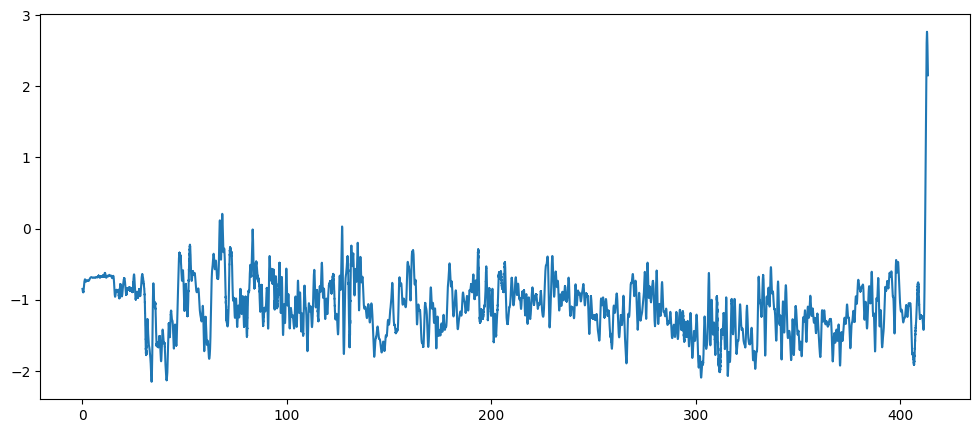

In [105]:
plt.figure(figsize=(12,5))
y = butter_bandstop_filter(data_1['y_acc'], 50, 1, 24)
plt.plot()
plt.plot(data_1['Time'], y)

In [106]:
y = butter_bandpass_filter(data_1['y_acc'], 50, 8, 20) + np.mean(data_1['y_acc'].to_numpy())

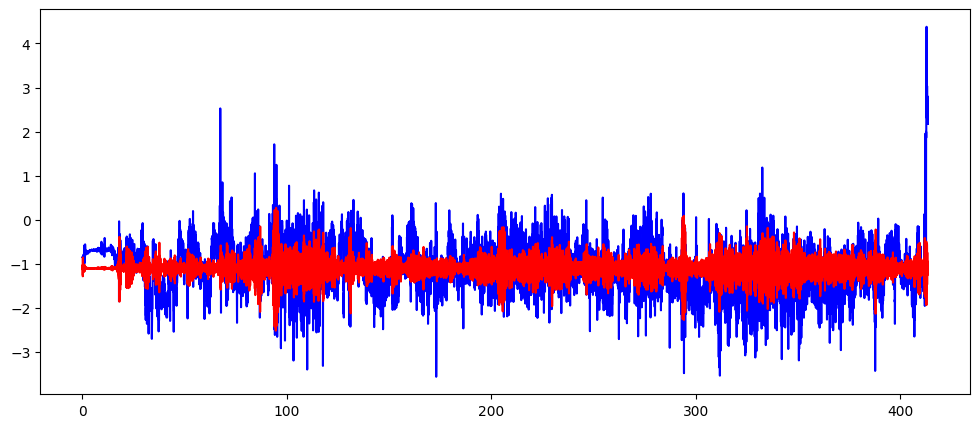

In [107]:
plt.figure(figsize=(12,5))
# plt.plot(data_1['Time'], y_, color = 'green')
plt.plot(data_1['Time'], data_1['y_acc'], color='blue')
plt.plot(data_1['Time'], y, color='red')
# plt.plot(data_1['Time'], y_y , color='pink')